In [1]:
from datetime import datetime
from dateutil.parser import parse
from pandas import DataFrame
import datetime as dt
import gender_guesser.detector as gendr
import gmaps
import googlemaps
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.plotly as py
import plotly.tools as tls
import pymysql
import random
import re
import requests
import time
import warnings
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

from smtplib import SMTP

import matplotlib.pyplot as plt

pd.options.display.max_columns = None
warnings.simplefilter(action='ignore')
data_path = "data/"


In [116]:
# 1. Load data for analysis

df = pd.read_csv(data_path + "2008_2018_full_data.csv")
df.job_category1.fillna('none', inplace=True)
df.job_category2.fillna('none', inplace=True)
df = df[df._gender_x!='unknown']

# 2. Second data set is adjusted for inflation
df_cut = df[df.salary_x>=df.cut_off_base_2008]

In [4]:
# define some common functions

def get_totals_year(x):
    return x.groupby(['c_year'])['last_name'].transform('count')

def get_totals_female_year(x):
    return x[(x._gender_x == 'female')].groupby(['c_year'])['last_name'].transform('count')

In [8]:

def female_by_year(df1):

    df1 = df1.assign(year_total=get_totals_year)
    df1 = df1.assign(year_total_female=get_totals_female_year)

    df1['per_females'] = df1.year_total_female/df1.year_total*100
    df1.groupby('c_year').agg({'year_total':np.max,'per_females':np.max})

    conns_un = DataFrame(df1.groupby(["c_year"]).per_females.max())
    conns_un['totals'] = 100
    conns_un.reset_index(inplace=True)
    conns_un.sort_values('per_females',inplace=True,ascending=False)

    fig, ax = plt.subplots(figsize=(25,10))

    plt.bar(conns_un.c_year,  conns_un.totals , width=0.8, label='Male', color=(0.1, 0.3, 0.4, 0.6))

    ctr = 0
    for a in ax.patches:
        plt.text(a.xy[0]+0.1, a.get_height()-80, str(round(conns_un.iloc[ctr, 1],1))+"%", 
                 color = 'w', rotation=90, fontsize=30)
        ctr+=1

    plt.bar(conns_un.c_year, conns_un.totals - (100-conns_un.per_females), width=0.8, 
            label='Female', color=(0.8, 0.1, 0.2, 0.5))

    ax.axes.tick_params(rotation=45, direction='out', length=6, width=2, colors='black',
                   grid_color='w', grid_alpha=0.5,labelsize=30 )

    plt.ylabel('', fontsize=40)
    plt.xlabel('', fontsize=40)
    plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))



Text(0.5,1,'% of female by year \n(numbers adjusted for Inflation)')

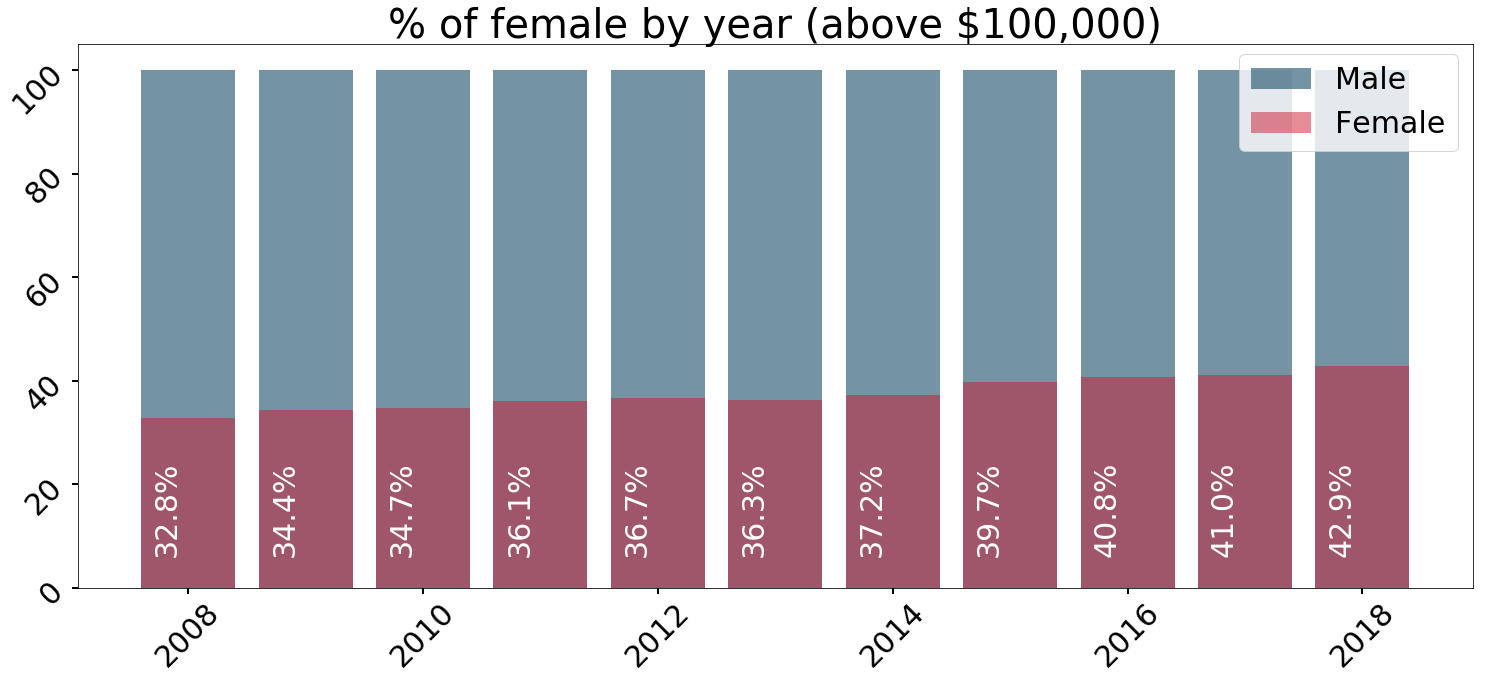

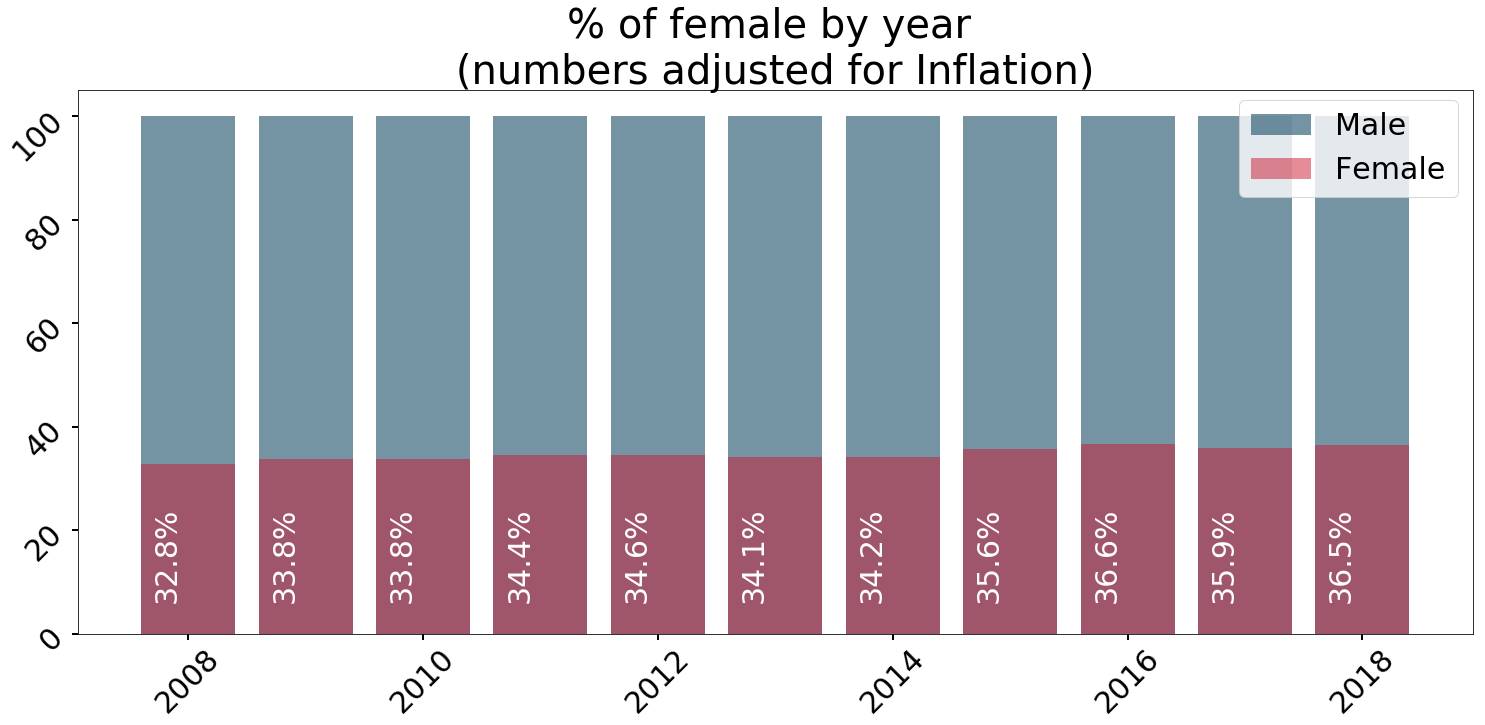

In [9]:
    
df1 = df.copy()
female_by_year(df1)
plt.title("% of female by year (above $100,000)", fontsize=40)

df1 = df_cut.copy()
female_by_year(df1)

plt.title("% of female by year \n(numbers adjusted for Inflation)", fontsize=40)

In [13]:

def female_by_sector(df1):
    df1 = df1[df1.c_year==2018]


    def get_totals(x):
        return x.groupby(['_sector'])['last_name'].transform('count')
    def get_totals_female(x):
        return x[(x._gender_x == 'female')].groupby(['_sector'])['last_name'].transform('count')

    df1 = df1.assign(year_total=get_totals)
    df1 = df1.assign(year_total_female=get_totals_female)
    df1['per_females'] = df1.year_total_female/df1.year_total*100
    df1.groupby('_sector').agg({'year_total':np.max,'per_females':np.max})

    conns_un = DataFrame(df1.groupby(["_sector"]).per_females.max())
    conns_un['totals'] = 100
    conns_un.reset_index(inplace=True)
    conns_un.sort_values('per_females',inplace=True,ascending=False)

    fig, ax = plt.subplots(figsize=(25,15))

    plt.barh(conns_un._sector,  conns_un.totals , label='Male', color=(0.1, 0.3, 0.4, 0.6))

    # colors = sns.diverging_palette(8, 200, sep=1, n=2)

    ctr = 0
    for a in ax.patches:
        plt.text(a.xy[0]+1, a.xy[1]+0.1, str(round(conns_un.iloc[ctr, 1],1))+"%", 
                 color = 'w', fontsize=40)
        ctr+=1

    plt.barh(conns_un._sector, conns_un.totals - (100-conns_un.per_females), 
            label='Female', color=(0.8, 0.1, 0.2, 0.5))

    ax.axes.tick_params(direction='out', length=6, width=2, colors='black',
                   grid_color='w', grid_alpha=0.5,labelsize=30 )

    plt.ylabel('', fontsize=40)
    plt.xlabel('', fontsize=40)
    plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))


Text(0.5,1,'% of female by sector in 2018 \n(numbers adjusted for Inflation, 2008 benchmark)')

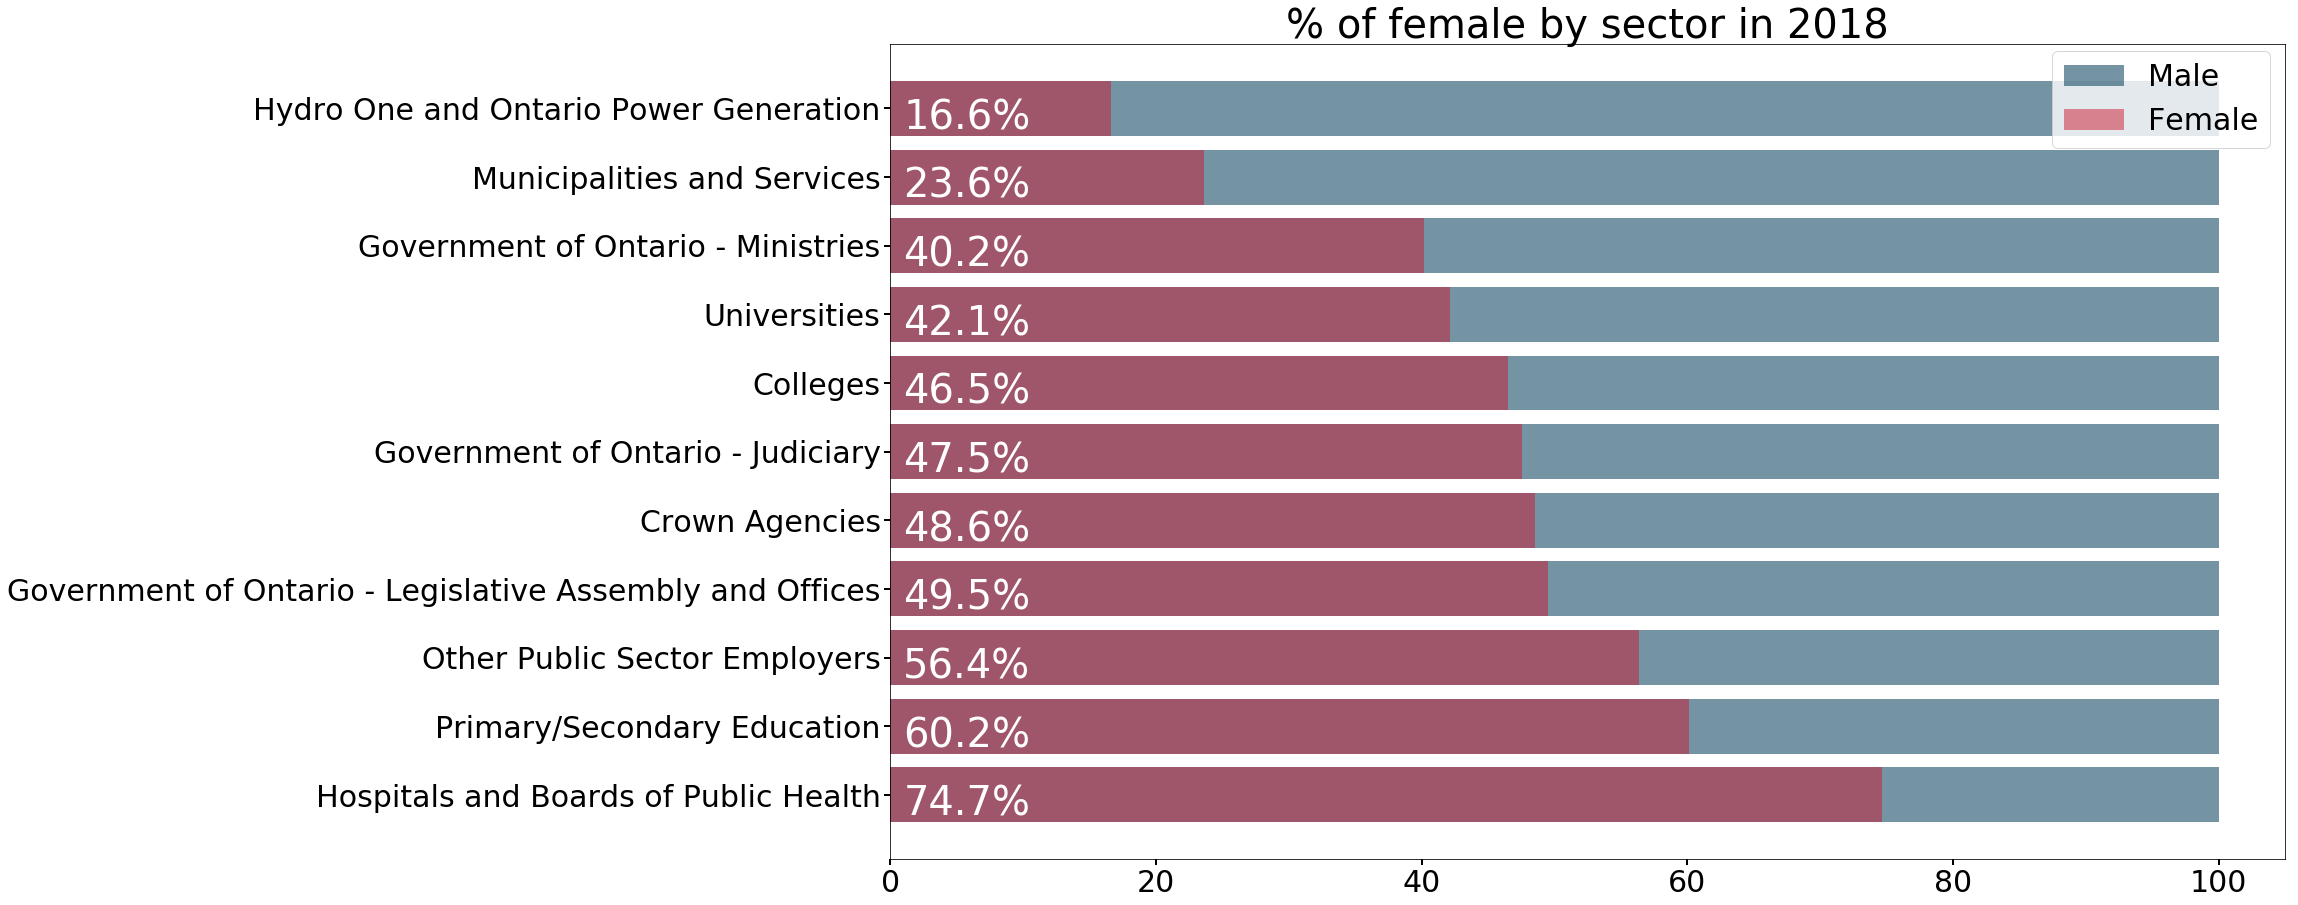

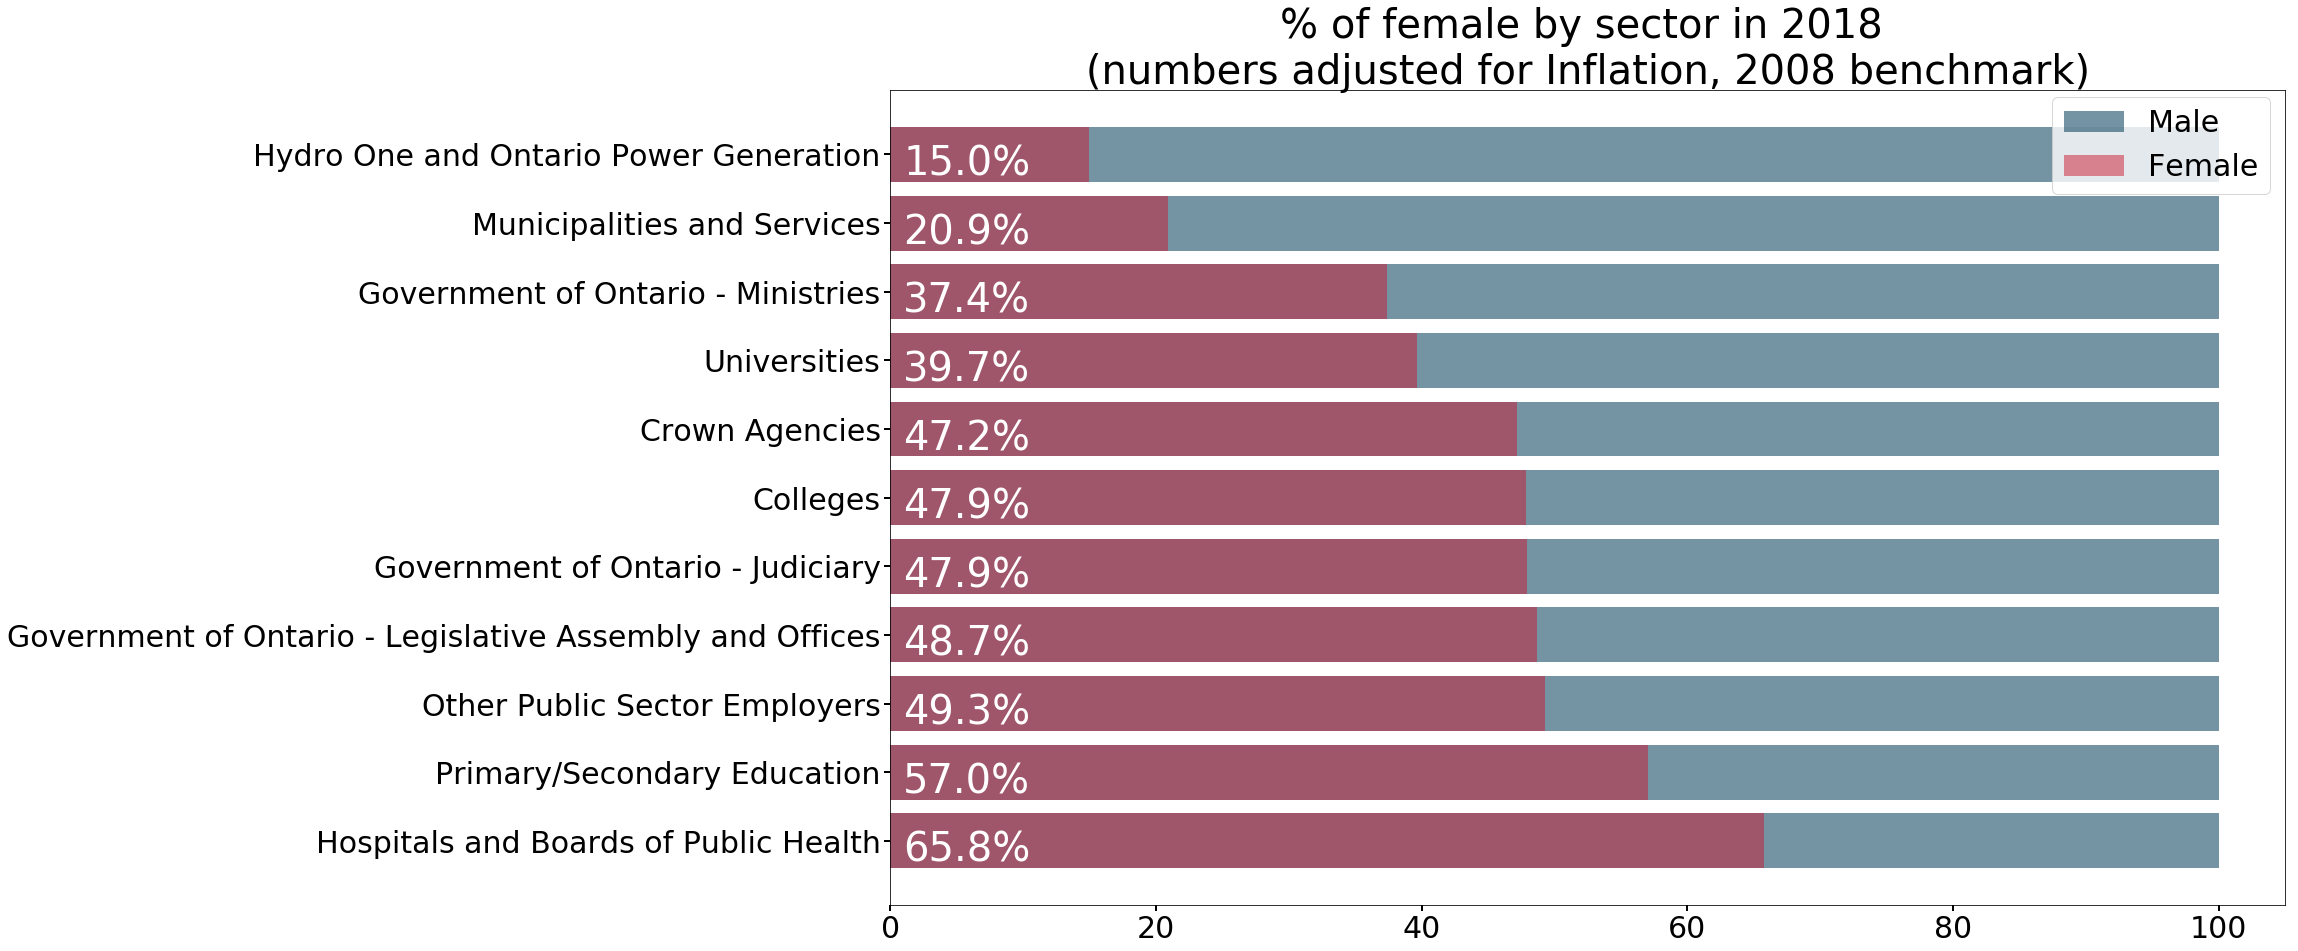

In [14]:

df1 = df.copy()
female_by_sector(df1)
plt.title("% of female by sector in 2018", fontsize=40)

df1 = df_cut.copy()
female_by_sector(df1)
plt.title("% of female by sector in 2018 \n(numbers adjusted for Inflation, 2008 benchmark)", fontsize=40)

Text(0.5,1,'% of female by job level in 2018')

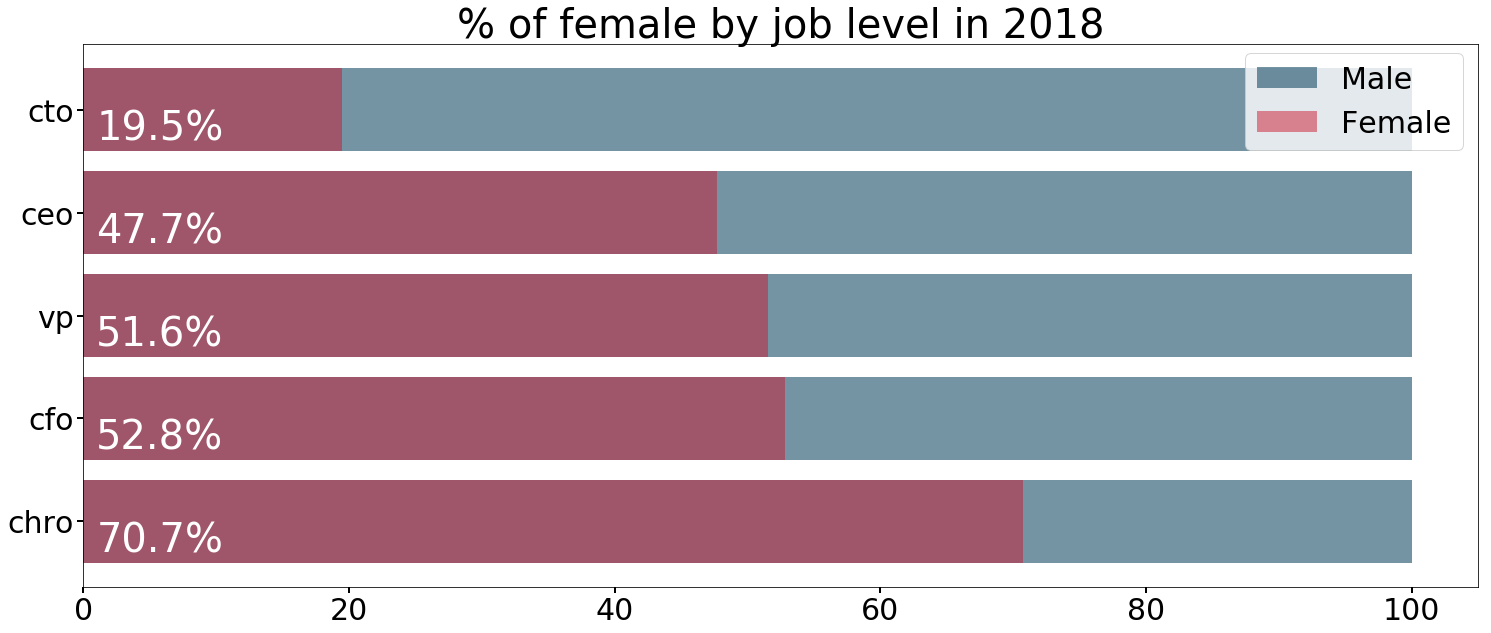

In [15]:

df1 = df.copy()
df1 = df1[df1.job_category1!='none']
df1 = df1[df1.c_year==2018]

def get_totals(x):
    return x.groupby(['job_category1'])['last_name'].transform('count')
def get_totals_female(x):
    return x[(x._gender_x == 'female')].groupby(['job_category1'])['last_name'].transform('count')

df1 = df1.assign(year_total=get_totals)
df1 = df1.assign(year_total_female=get_totals_female)
df1['per_females'] = df1.year_total_female/df1.year_total*100
df1.groupby('job_category1').agg({'year_total':np.max,'per_females':np.max})

conns_un = DataFrame(df1.groupby(["job_category1"]).per_females.max())
conns_un['totals'] = 100
conns_un.reset_index(inplace=True)
conns_un.sort_values('per_females',inplace=True,ascending=False)

fig, ax = plt.subplots(figsize=(25,10))

plt.barh(conns_un.job_category1,  conns_un.totals , label='Male', color=(0.1, 0.3, 0.4, 0.6))

ctr = 0
for a in ax.patches:
    plt.text(a.xy[0]+1, a.xy[1]+0.1, str(round(conns_un.iloc[ctr, 1],1))+"%", 
             color = 'w', fontsize=40)
    ctr+=1
    
plt.barh(conns_un.job_category1, conns_un.totals - (100-conns_un.per_females), 
        label='Female', color=(0.8, 0.1, 0.2, 0.5))

ax.axes.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='w', grid_alpha=0.5,labelsize=30 )

plt.ylabel('', fontsize=40)
plt.xlabel('', fontsize=40)
plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))

plt.title("% of female by job level in 2018", fontsize=40)

Text(0.5,1,'% Chiefs in 2018')

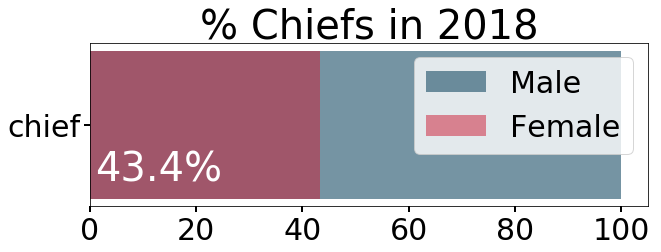

In [16]:

df1 = df.copy()
df1 = df1[df1.job_category2!='none']
df1 = df1[df1.c_year==2018]

def get_totals(x):
    return x.groupby(['job_category2'])['last_name'].transform('count')
def get_totals_female(x):
    return x[(x._gender_x == 'female')].groupby(['job_category2'])['last_name'].transform('count')

df1 = df1.assign(year_total=get_totals)
df1 = df1.assign(year_total_female=get_totals_female)
df1['per_females'] = df1.year_total_female/df1.year_total*100
df1.groupby('job_category2').agg({'year_total':np.max,'per_females':np.max})

conns_un = DataFrame(df1.groupby(["job_category2"]).per_females.max())
conns_un['totals'] = 100
conns_un.reset_index(inplace=True)
conns_un.sort_values('per_females',inplace=True,ascending=False)

fig, ax = plt.subplots(figsize=(10,3))

plt.barh(conns_un.job_category2,  conns_un.totals , label='Male', color=(0.1, 0.3, 0.4, 0.6))

ctr = 0
for a in ax.patches:
    plt.text(a.xy[0]+1, a.xy[1]+0.1, str(round(conns_un.iloc[ctr, 1],1))+"%", 
             color = 'w', fontsize=40)
    ctr+=1
    
plt.barh(conns_un.job_category2, conns_un.totals - (100-conns_un.per_females), 
        label='Female', color=(0.8, 0.1, 0.2, 0.5))

ax.axes.tick_params(direction='out', length=6, width=2, colors='black',
               grid_color='w', grid_alpha=0.5,labelsize=30 )

plt.ylabel('', fontsize=40)
plt.xlabel('', fontsize=40)
plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))

plt.title("% Chiefs in 2018", fontsize=40)

Text(0.5,1,'Salaries by gender by title in 2018')

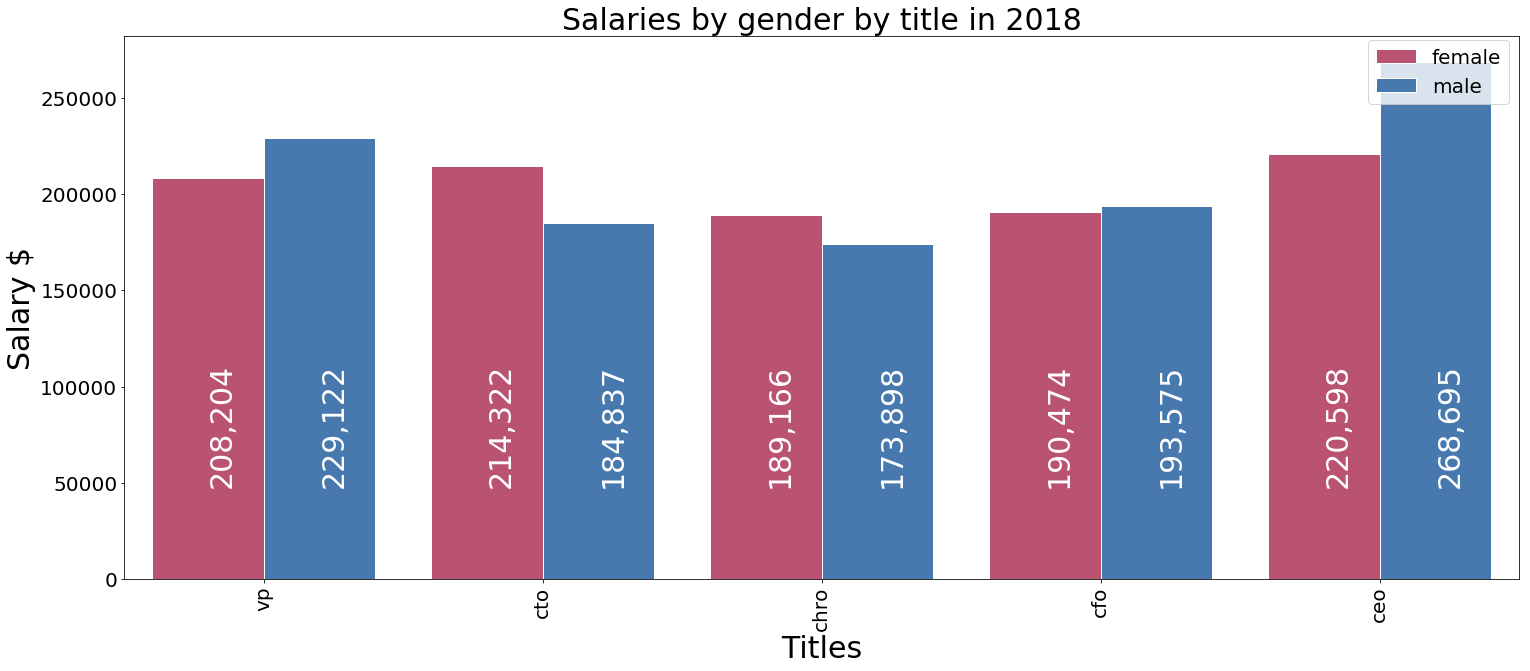

In [19]:

df1 = df_cut.copy()
df1 = df1[df1.job_category1!='none']
df1 = df1[df1.c_year==2018]

plt.figure(figsize=(25,10))

df1 = DataFrame(df1.groupby(['job_category1','_gender_x'])['salary_x'].mean())
df1.reset_index(inplace=True)

df1.sort_values('job_category1',inplace=True,ascending=False)

colors = [ "dark pink",  "windows blue"]

g = sns.barplot(x='job_category1', y='salary_x',hue="_gender_x", data=df1,  
                palette=sns.xkcd_palette(colors),  edgecolor='white', alpha = 1)

ctr = 0
ctr1 = 0
ctr2 = -0.2
for a in g.patches:
#     print (a)
    try:
        plt.text(ctr1+ctr2, 100000, "{:,}".format(int(df1.iloc[ctr, 2])), 
         color = 'w', rotation=90, fontsize=30)
    except:
        pass
    ctr+=1
    if (ctr%2==0):
        ctr1 +=1
        ctr2 = -0.2
    else:
        ctr2 = 0.2

for item in g.get_yticklabels():
    item.set_fontsize(20)
for item in g.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(20)
    
plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 1.01))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Titles', fontsize=30)
plt.title("Salaries by gender by title in 2018", fontsize=30)


Text(0.5,1,'Salaries of C-Suite by gender in 2018')

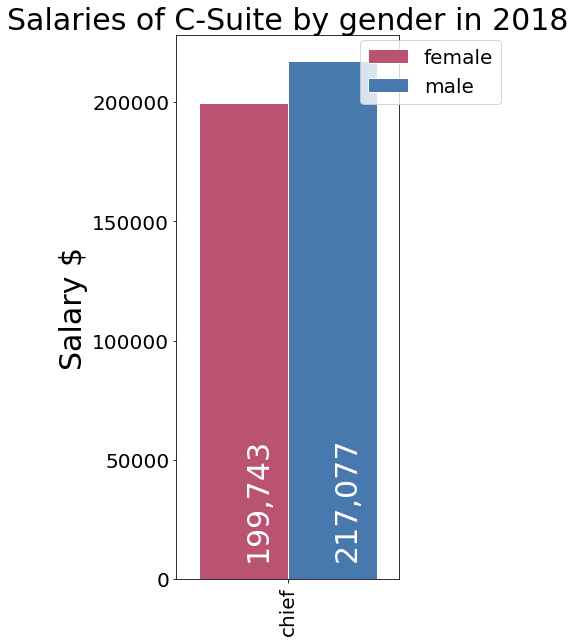

In [34]:
df1 = df_cut.copy()
df1 = df1[df1.job_category2!='none']
df1 = df1[df1.c_year==2018]

plt.figure(figsize=(4,10))

df1 = DataFrame(df1.groupby(['job_category2','_gender_x'])['salary_x'].mean())
df1.reset_index(inplace=True)

df1.sort_values('job_category2',inplace=True,ascending=False)

colors = [ "dark pink",  "windows blue"]

g = sns.barplot(x='job_category2', y='salary_x',hue="_gender_x", data=df1,  
                palette=sns.xkcd_palette(colors),  edgecolor='white', alpha = 1)

ctr = 0
ctr1 = 0
ctr2 = -0.2
for a in g.patches:
#     print (a)
    try:
        plt.text(ctr1+ctr2, 50000, "{:,}".format(int(df1.iloc[ctr, 2])), 
         color = 'w', rotation=90, fontsize=30)
    except:
        pass
    ctr+=1
    if (ctr%2==0):
        ctr1 +=1
        ctr2 = -0.2
    else:
        ctr2 = 0.2

for item in g.get_yticklabels():
    item.set_fontsize(20)
for item in g.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(20)
    
plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.5, 1.01))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('', fontsize=30)
plt.title("Salaries of C-Suite by gender in 2018", fontsize=30)


Text(0.5,1,'Salaries of CEO jobs by gender by sector in 2018')

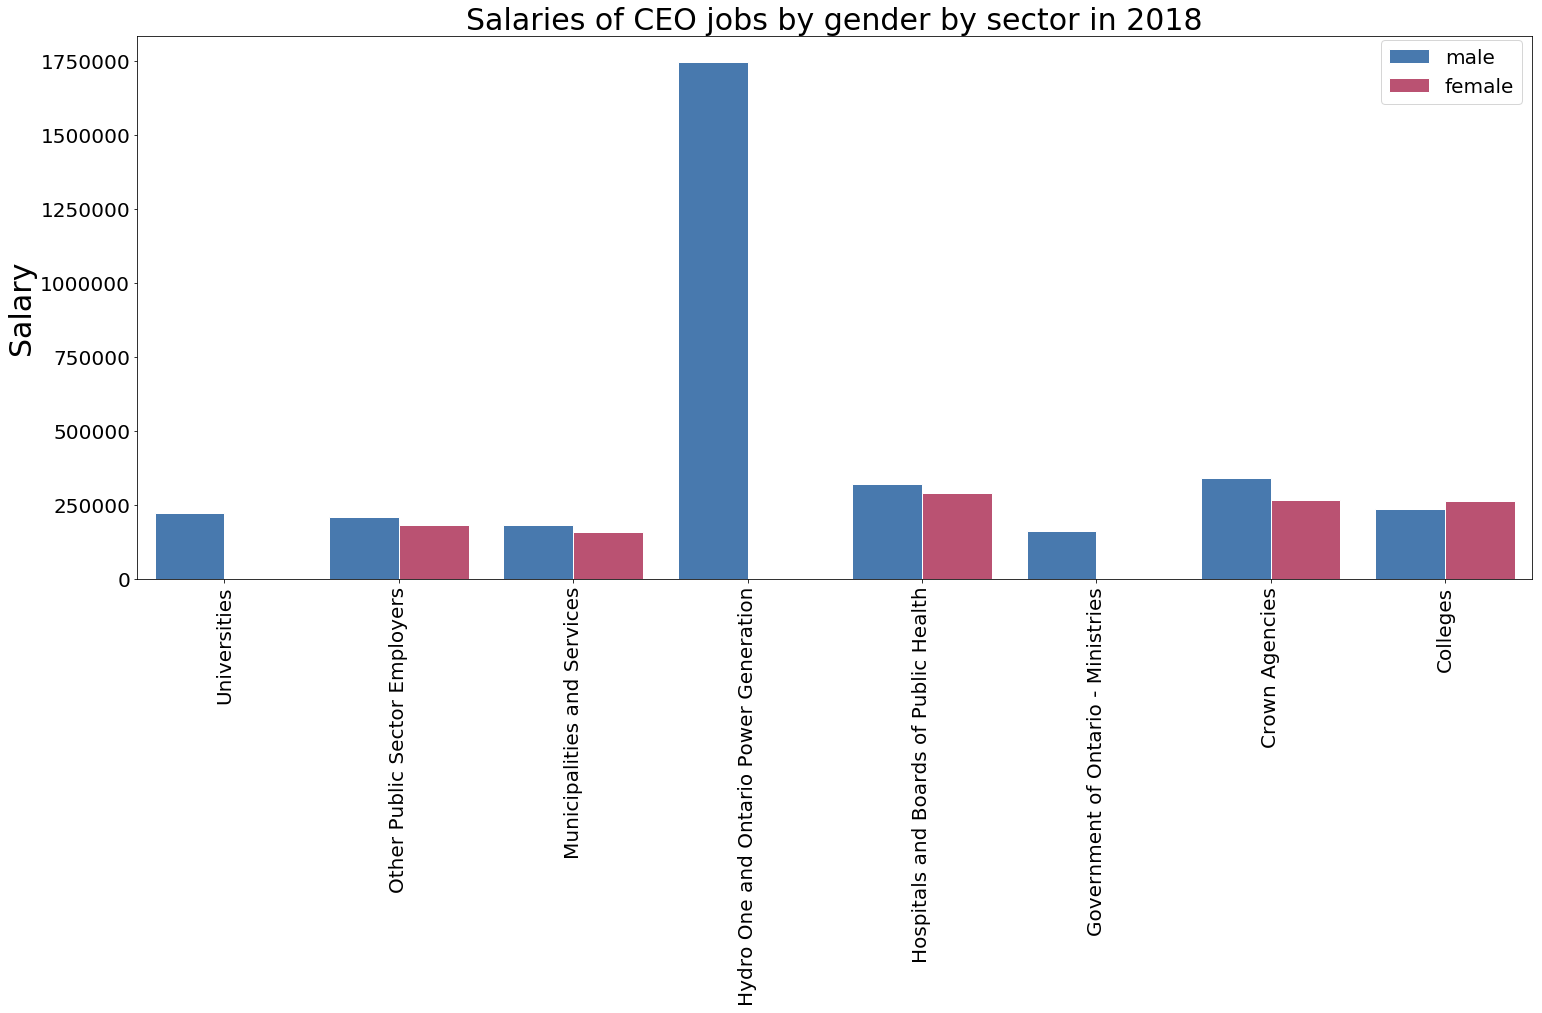

In [35]:

df1 = df_cut.copy()
df1 = df1[df1.c_year==2018]
df1 = df1[df1.job_category1=='ceo']

plt.figure(figsize=(25,10))

df1 = DataFrame(df1.groupby(['_sector','_gender_x'])['salary_x'].mean())
df1.reset_index(inplace=True)

df1.sort_values('_sector',inplace=True,ascending=False)

colors = [   "windows blue", "dark pink"]

g = sns.barplot(x='_sector', y='salary_x',hue="_gender_x", data=df1,  
                palette=sns.xkcd_palette(colors),  edgecolor='white', alpha = 1)

ctr = 0
ctr1 = 0
ctr2 = -0.2

for item in g.get_yticklabels():
    item.set_fontsize(20)
for item in g.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(20)
    
plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 1.01))
plt.ylabel('Salary', fontsize=30)
plt.xlabel('', fontsize=30)
plt.title("Salaries of CEO jobs by gender by sector in 2018", fontsize=30)

Text(0.5,1,'Salaries by gender by Sector in 2018\n(numbers adjusted for Inflation, 2008 benchmark)')

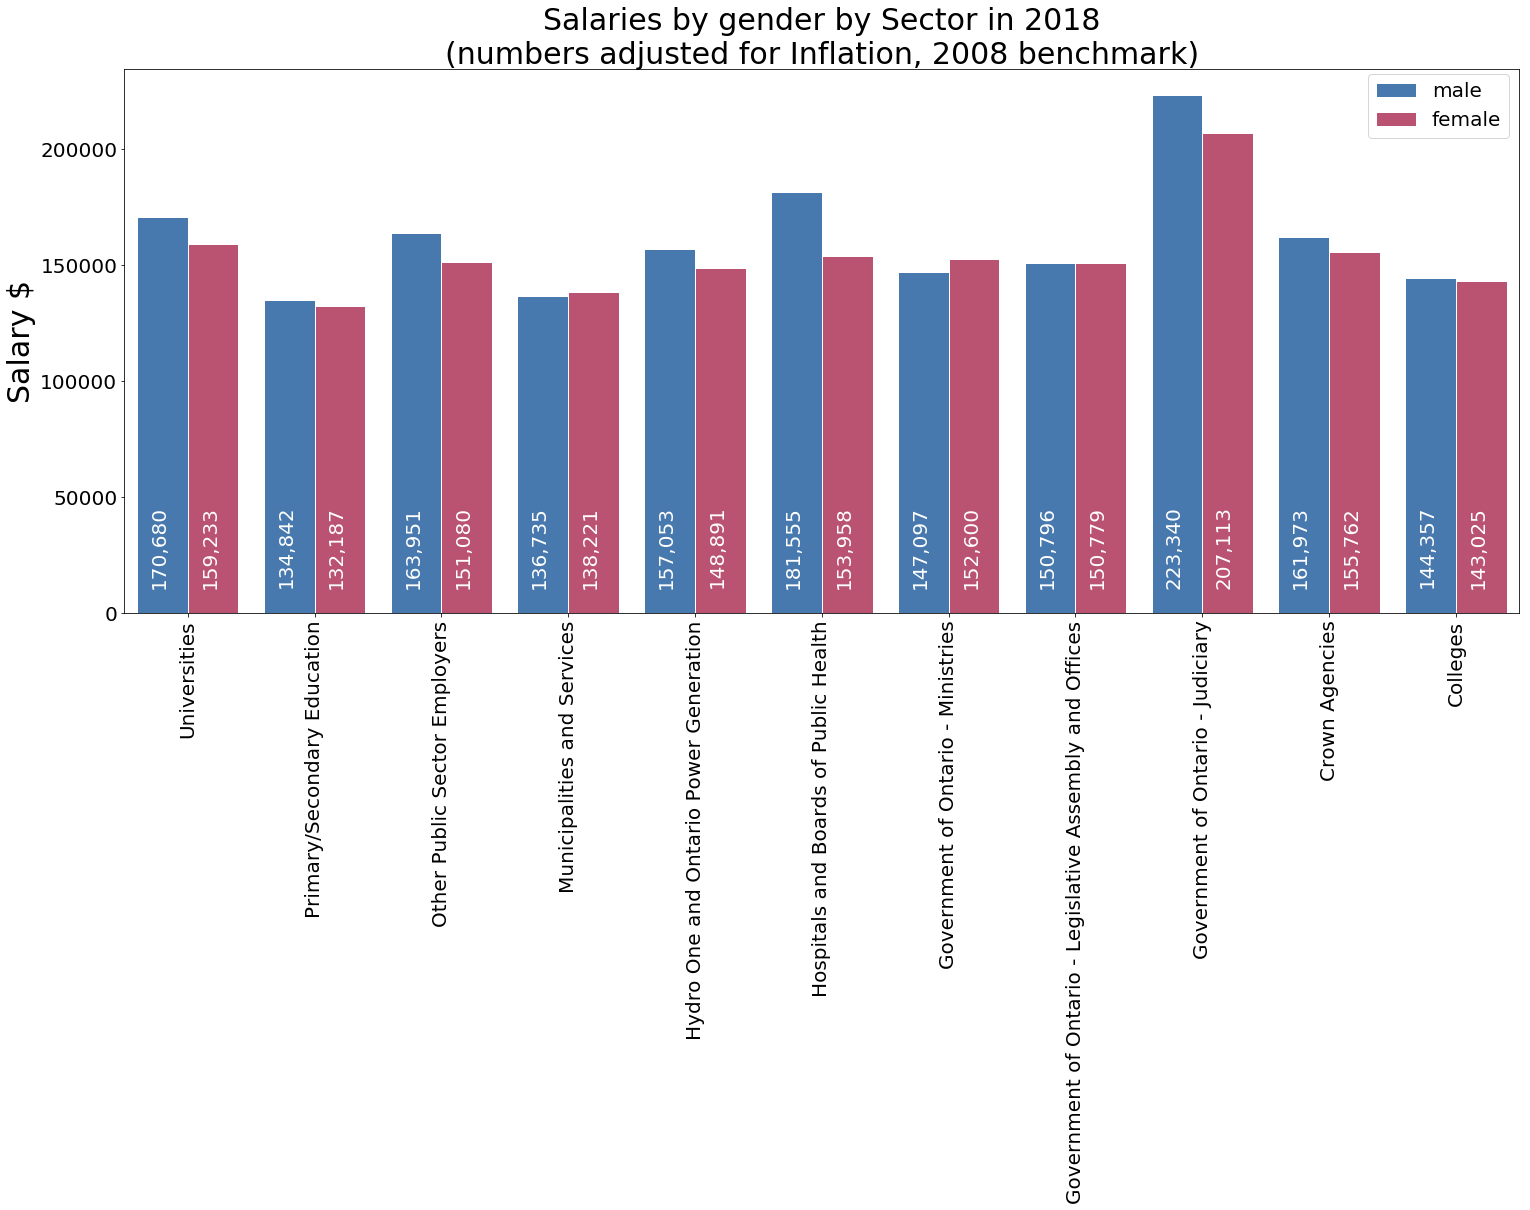

In [24]:

df1 = df_cut.copy()
df1 = df1[df1.c_year==2018]

plt.figure(figsize=(25,10))

df1 = DataFrame(df1.groupby(['_sector','_gender_x'])['salary_x'].mean())
df1.reset_index(inplace=True)

df1.sort_values('_sector',inplace=True,ascending=False)

colors = [ "windows blue", "dark pink"]

g = sns.barplot(x='_sector', y='salary_x',hue="_gender_x", data=df1,  
                palette=sns.xkcd_palette(colors),  edgecolor='white', alpha = 1)
ctr = 0
ctr1 = 0
ctr2 = -0.2

for a in g.patches:

    try:
        plt.text(a.get_x()+0.1, 40000, "{:,}".format(int(a.get_height())), 
         color = 'w', rotation=90, fontsize=20)
    except:
        pass
    ctr+=1    
    
    if (ctr%2==0):
        ctr1 +=1
        ctr2 = -0.2
    else:
        ctr2 = 0.2

for item in g.get_yticklabels():
    item.set_fontsize(20)
for item in g.get_xticklabels():
    item.set_rotation(90)
    item.set_fontsize(20)
    
plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 1.01))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('', fontsize=30)
plt.title("Salaries by gender by Sector in 2018\n(numbers adjusted for Inflation, 2008 benchmark)", fontsize=30)

Text(0.5,1,'Salary distribution by Sector in 2018')

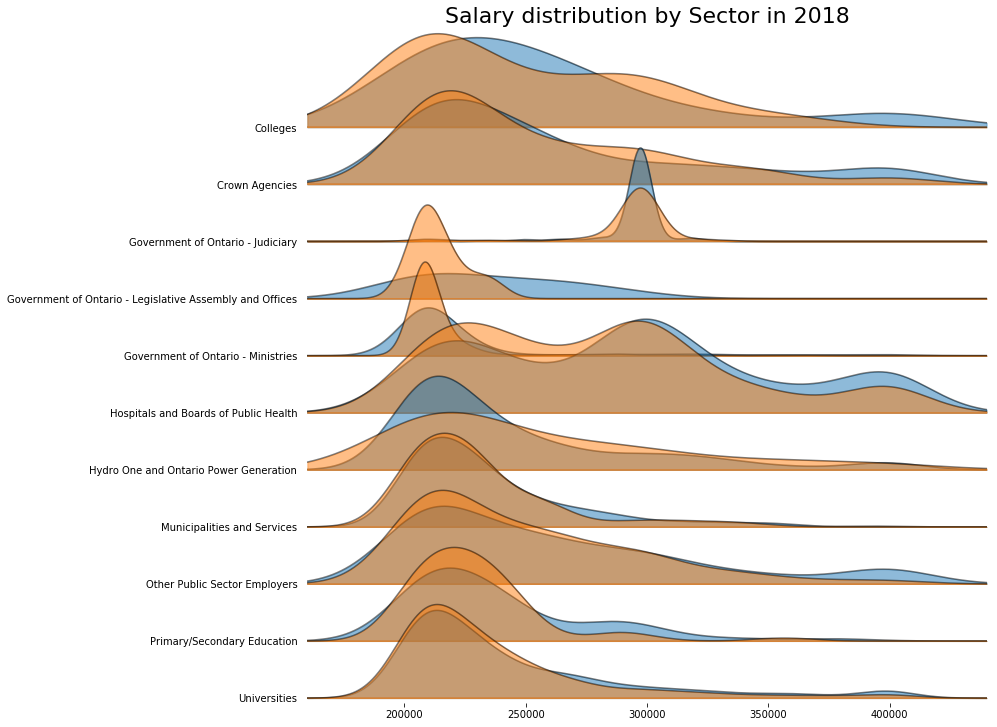

In [31]:
# !pip install joypy

df1 = df_cut.copy()
df1 = df1[df1.c_year==2018]
df1 = df1[df1.salary_x>200000]
df1.salary_m = [i if i < 400000 else 400000 for i in df1.salary_m]
df1.salary_f = [i if i < 400000 else 400000 for i in df1.salary_f]

df_m = df1[df1.salary_m >0][['_sector','salary_m']]
df_f = df1[df1.salary_f >0][['_sector','salary_f']]

# dd = pd.merge(df_m,df_f, how='left')

dd = pd.concat([df_m,df_f])
fig, axes = joypy.joyplot(dd, column=[ 'salary_m', 'salary_f', ], by="_sector", ylim='own', figsize=(14,10), alpha=0.5,)
plt.title('Salary distribution by Sector in 2018', fontsize=22)



Text(0.5,0,'')

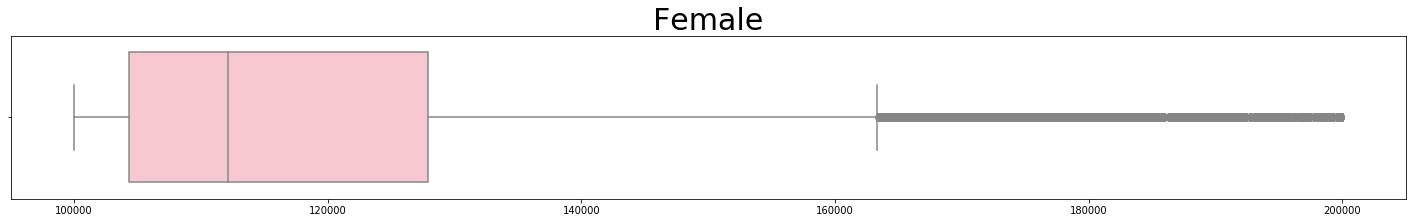

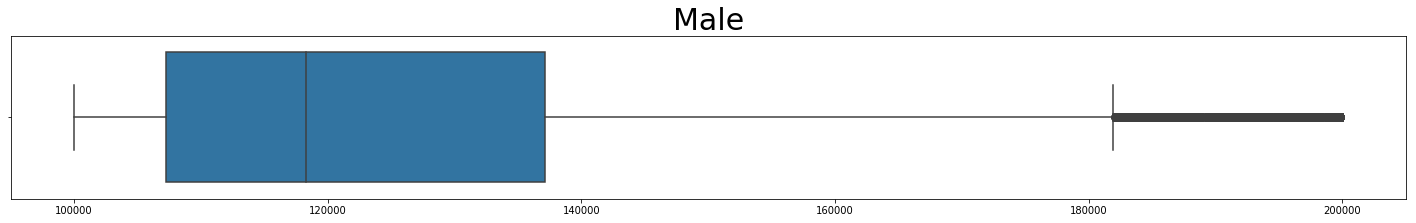

In [42]:

fig, ax = plt.subplots(figsize=(25,3))
df1 = df.copy()
df1 = df1[df1._gender_x=='female']
df1 = df1[df1.c_year==2018]
df1.salary_x = [i if i < 200000 else 200000 for i in df1.salary_x]
ax = sns.boxplot(x="salary_x", data=df1, color = 'pink')
ax.set_title("Female", fontsize=30)
plt.xlabel('', fontsize=30)

fig, ax = plt.subplots(figsize=(25,3))
df1 = df.copy()
df1 = df1[df1._gender_x=='male']
df1 = df1[df1.c_year==2018]
df1.salary_x = [i if i < 200000 else 200000 for i in df1.salary_x]

ax = sns.boxplot(x="salary_x", data=df1)
ax.set_title("Male", fontsize=30)
plt.xlabel('', fontsize=30)

In [ ]:
df._gender_x.value_counts()

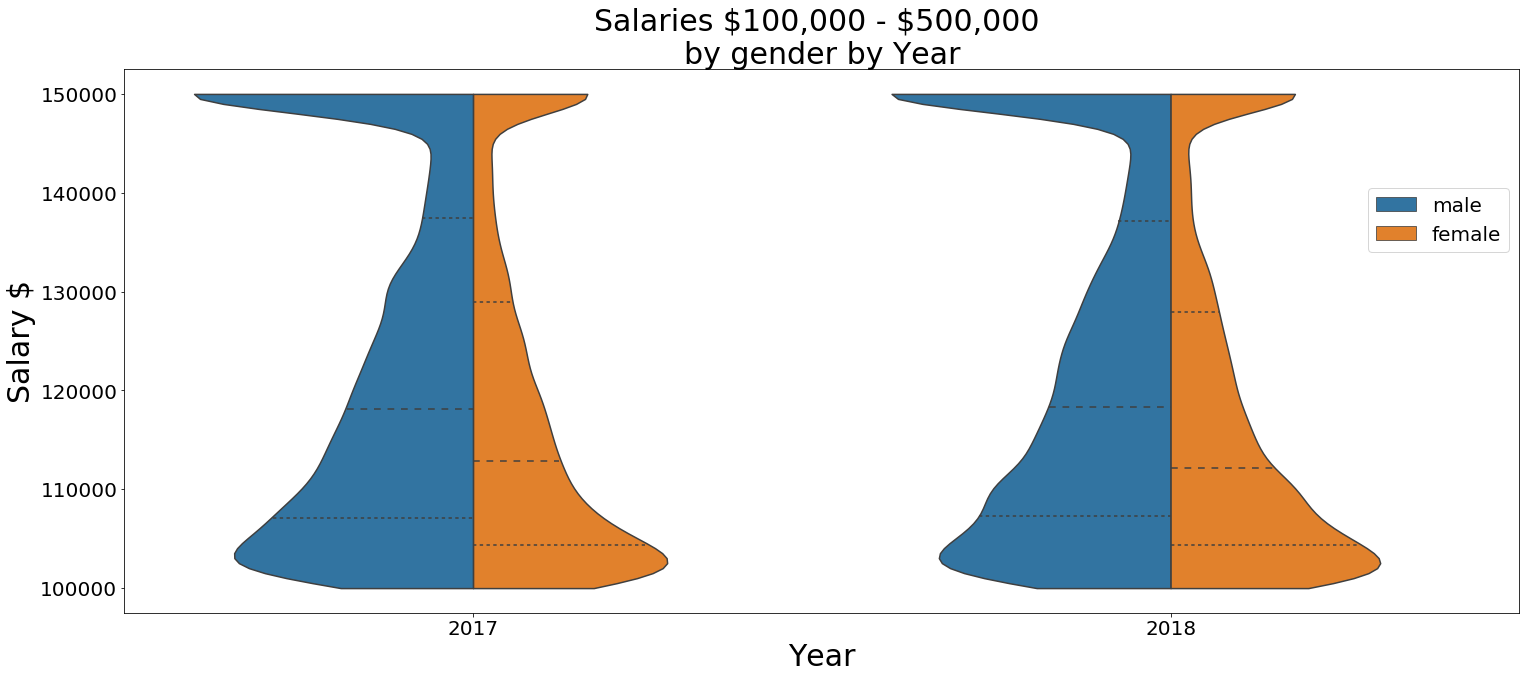

In [49]:
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2016]
df1 = df1[df1.salary_x<500000]
df1.salary_x = [i if i < 150000 else 150000 for i in df1.salary_x]

sns.violinplot(x="c_year", y="salary_x", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=True)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Salaries \$100,000 - \$500,000 \nby gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)


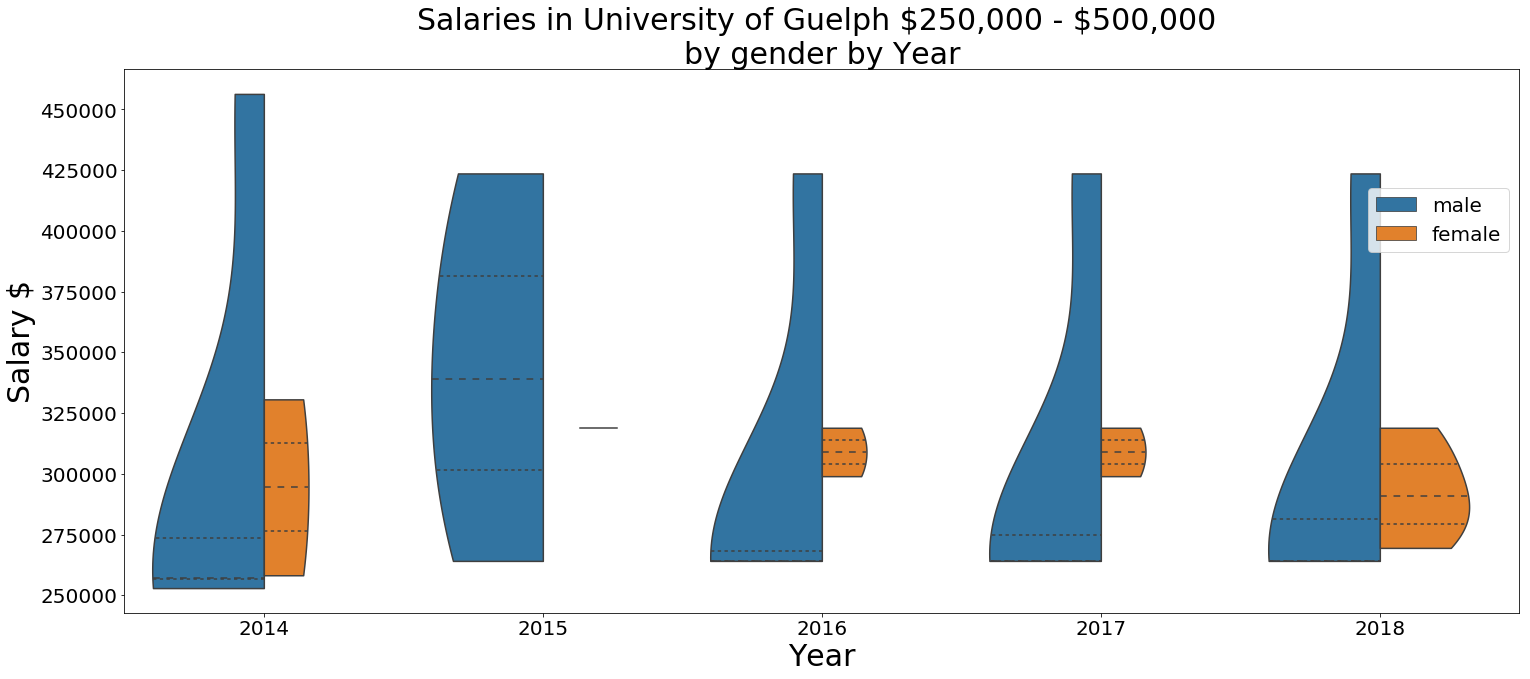

In [50]:
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = df1[df1.company == 'University of Guelph']
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2013]
df1 = df1[df1.salary_x>250000]
# df1.salary_x = [i if i < 150000 else 150000 for i in df1.salary_x]


sns.violinplot(x="c_year", y="salary_x", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=True)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Salaries in University of Guelph \$250,000 - \$500,000 \nby gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)


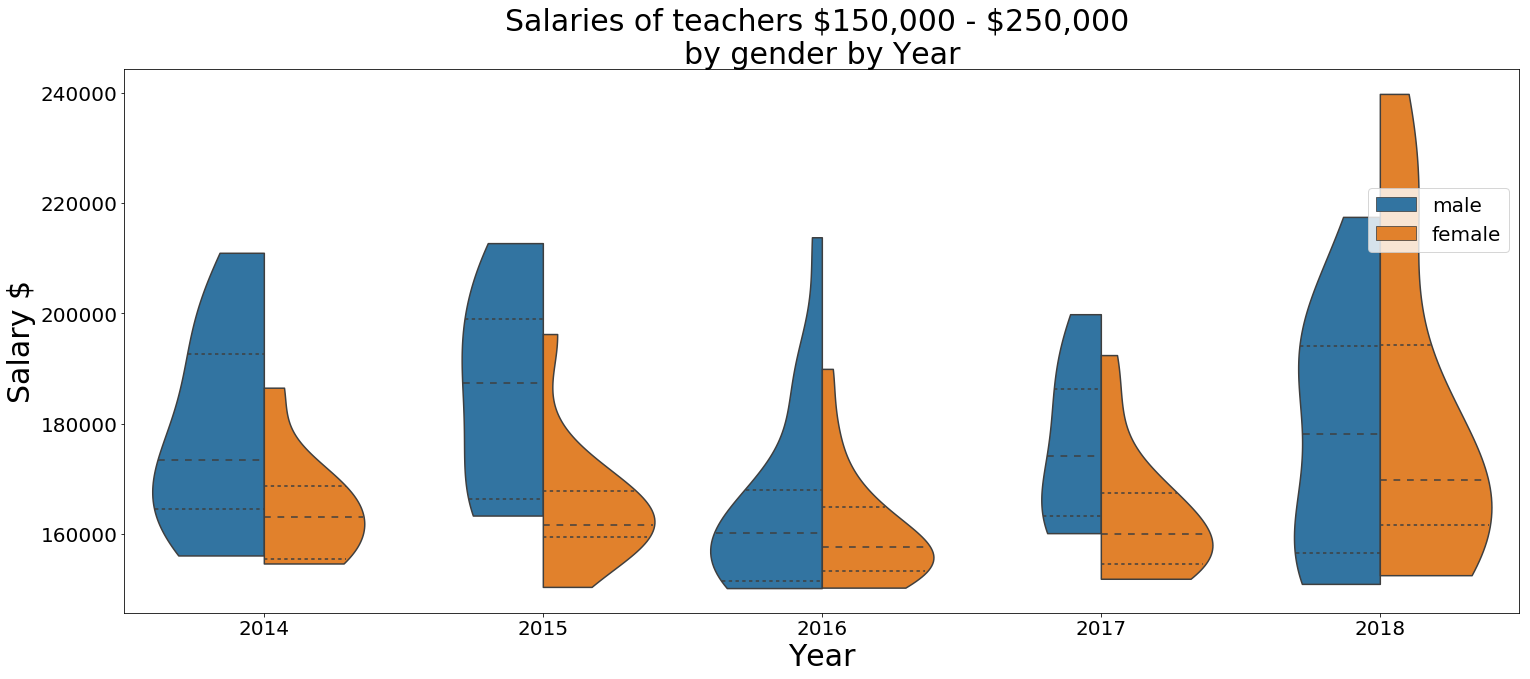

In [51]:
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = df1[df1._title.str.contains("teacher")]
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2013]
df1 = df1[df1.salary_x>150000]
# df1.salary_x = [i if i < 150000 else 150000 for i in df1.salary_x]


sns.violinplot(x="c_year", y="salary_x", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=False)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Salaries of teachers \$150,000 - \$250,000 \nby gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)


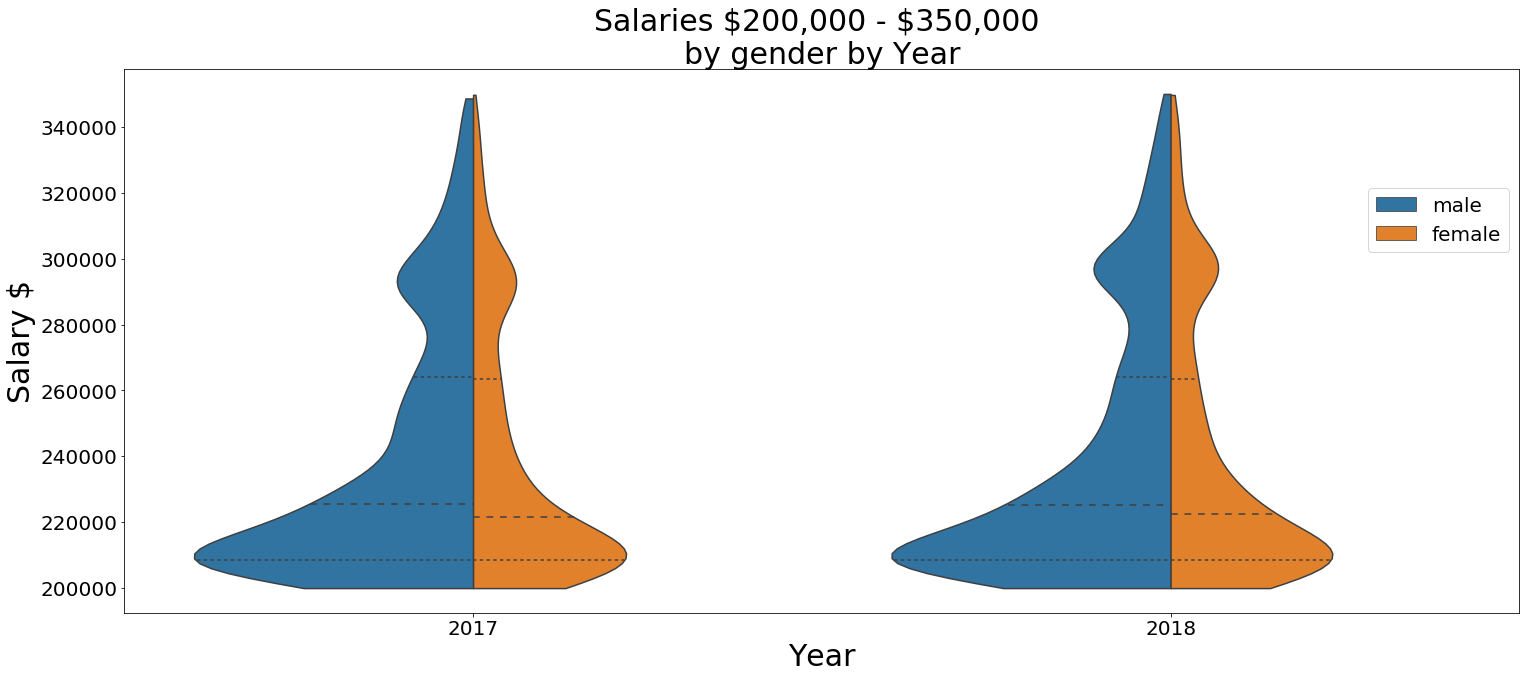

In [52]:
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2016]
# df1.salary_x = [i if i < 150000 else 150000 for i in df1.salary_x]
df1 = df1[df1.salary_x>200000]
df1 = df1[df1.salary_x<350000]

# df1._gender_x.value_counts()


sns.violinplot(x="c_year", y="salary_x", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=True)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Salaries \$200,000 - \$350,000 \nby gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)


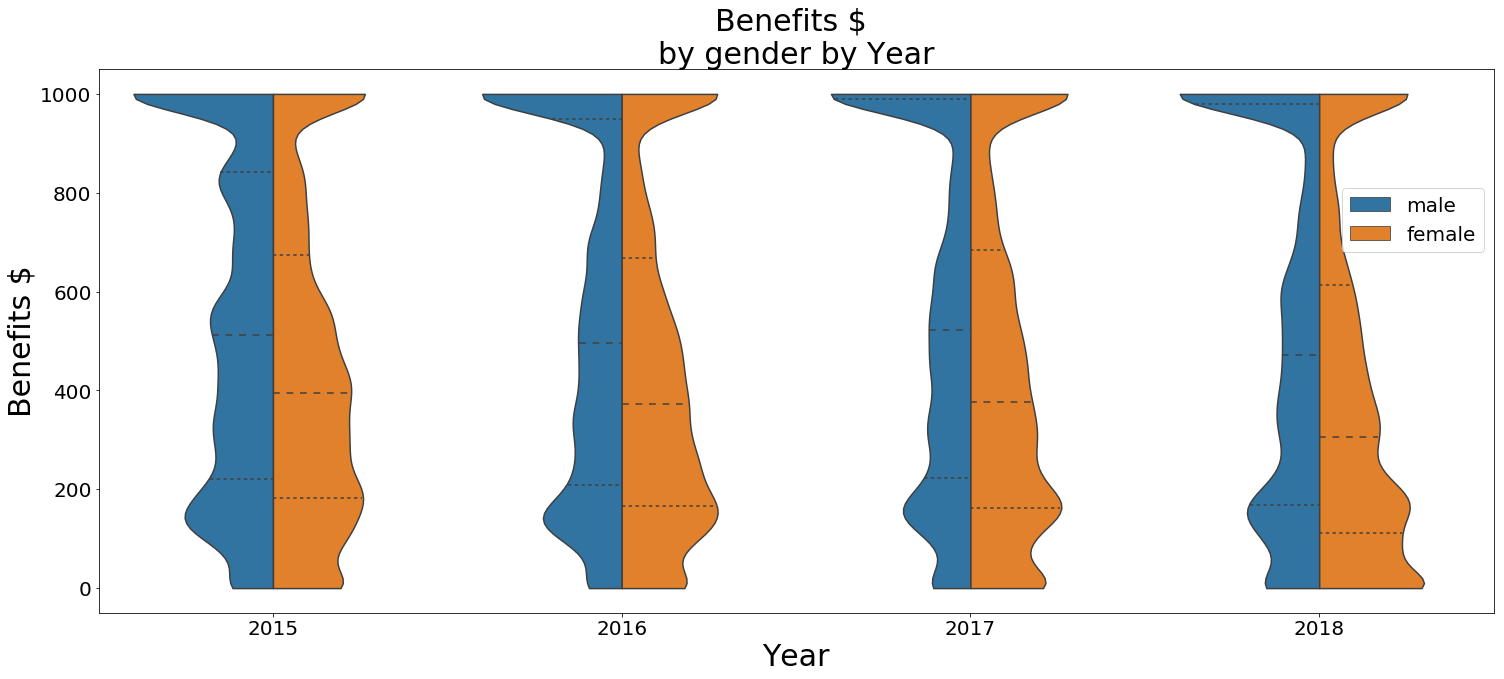

In [53]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2014]
df1.benefits = [i if i < 1000 else 1000 for i in df1.benefits]

sns.violinplot(x="c_year", y="benefits", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=False)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Benefits $', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Benefits $ \nby gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

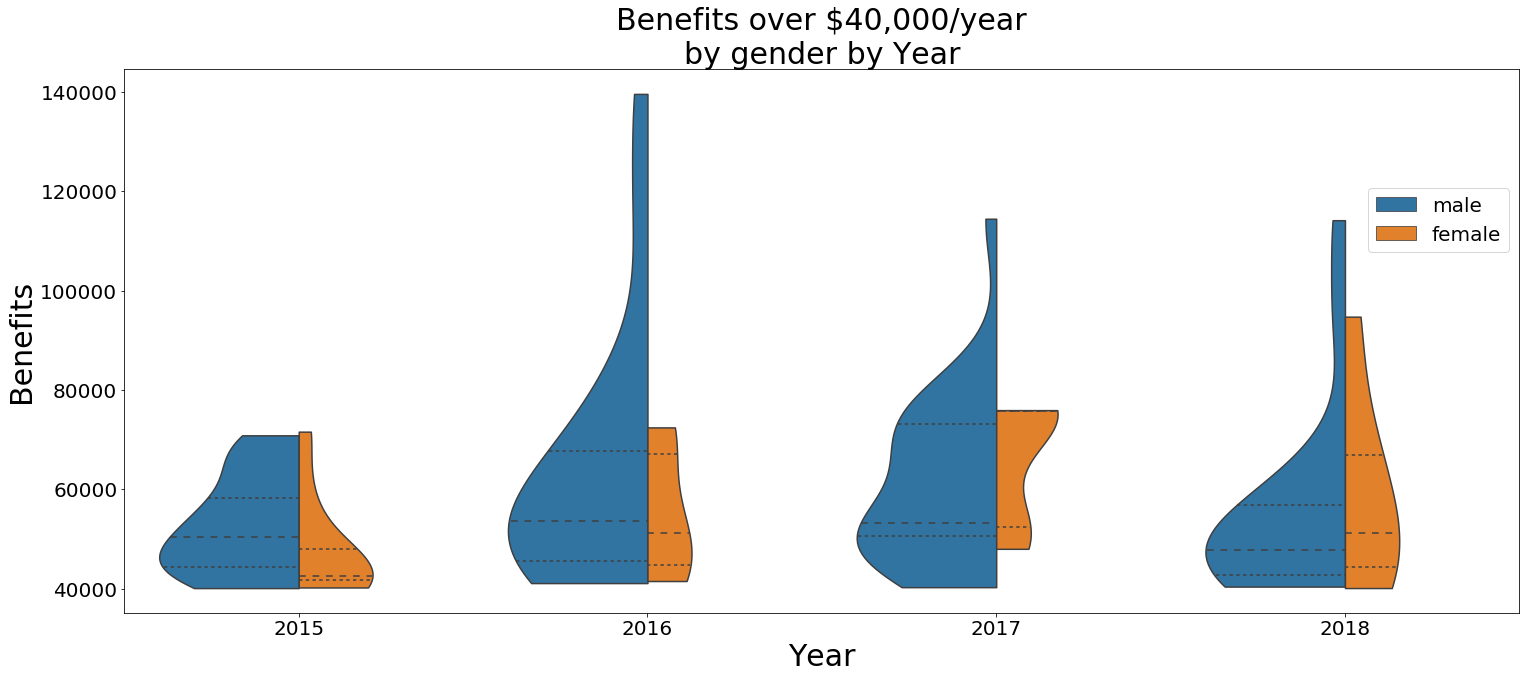

In [54]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2014]
# df1.benefits = [i if i < 1000 else 1000 for i in df1.benefits]
df1 = df1[df1.benefits>40000]

sns.violinplot(x="c_year", y="benefits", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=False)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Benefits', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Benefits over $40,000/year\nby gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

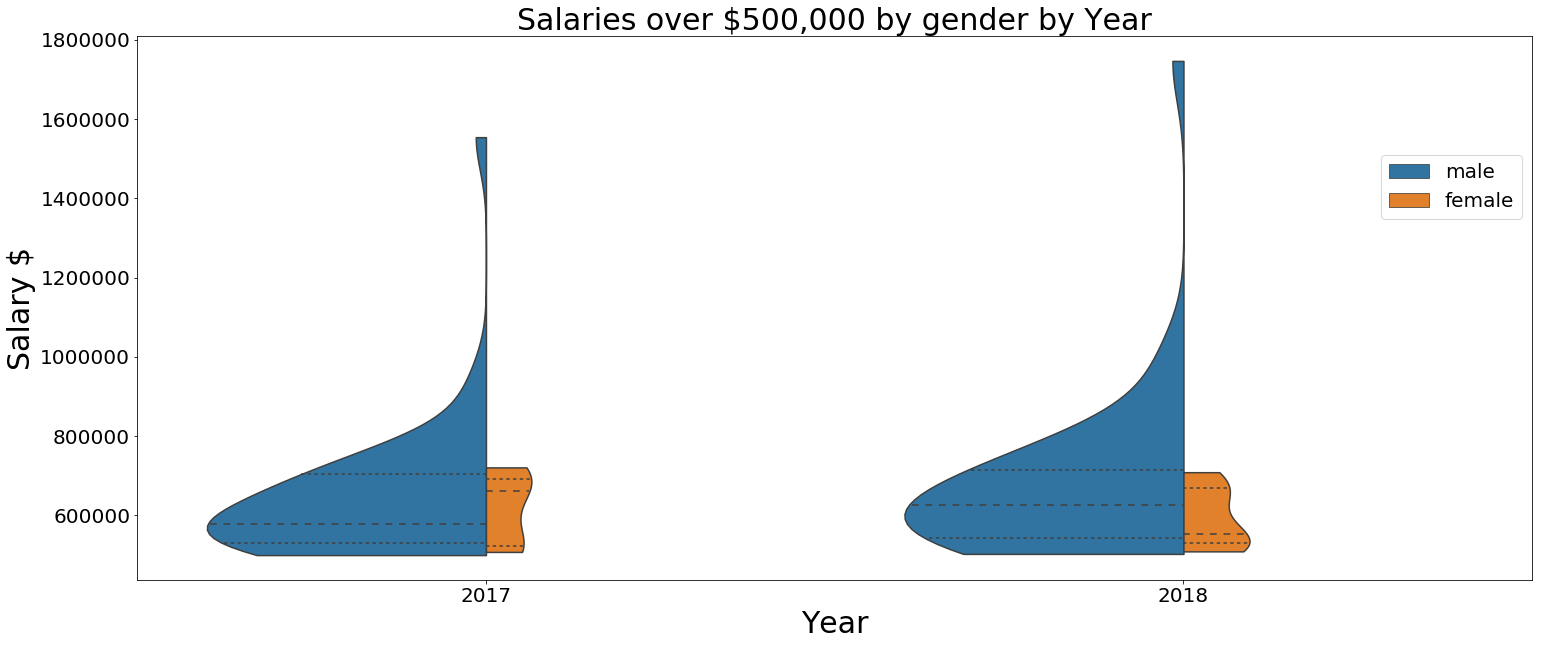

In [55]:
fig, ax = plt.subplots(figsize=(25,10))
df1 = df.copy()
df1 = pd.concat([df1[df1._gender_x=='male'],df1[df1._gender_x=='female']])
df1 = df1[df1.c_year>2016]
# df1.salary_x = [i if i < 250000 else 250000 for i in df1.salary_x]
df1 = df1[df1.salary_x>500000]

# df1._gender_x.value_counts()


sns.violinplot(x="c_year", y="salary_x", hue="_gender_x", data=df1,cut=0,
               split=True,  trim=True, scale="count", inner="quartile", dodge=True)

plt.legend(loc="upper right", fontsize=20, title="", bbox_to_anchor=(1.0, 0.8))
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)
plt.title("Salaries over \$500,000 by gender by Year", fontsize=30)
for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

Text(0.5,1,'Salary desctribution in 2018\nAll sectors')

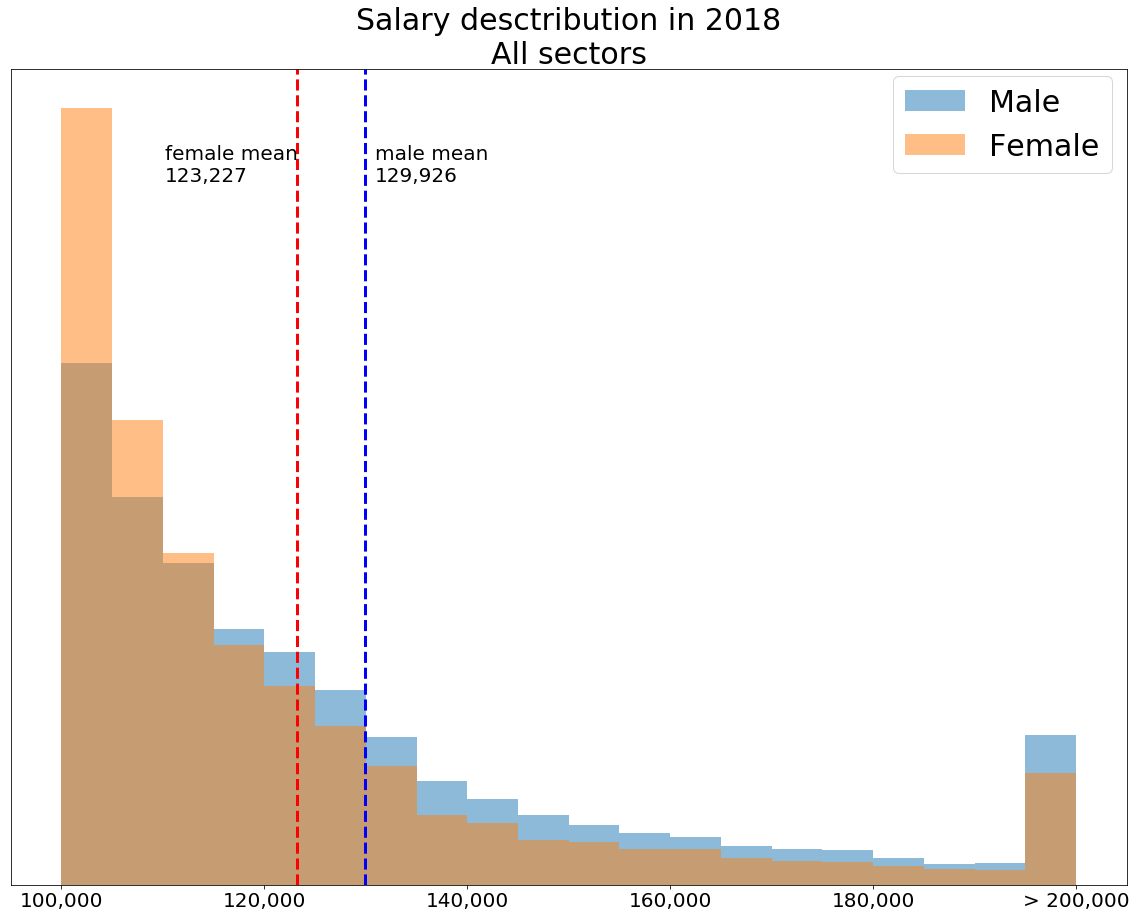

In [57]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(20,15))

df1 = df.copy()
df1 = df1[df1._gender_x=='male']
df1 = df1[df1.c_year==2018]
male_mean = df1.salary_x.mean()
df1.salary_x = [i if i < 200000 else 200000 for i in df1.salary_x]

df2 = df.copy()
df2 = df2[df2._gender_x=='female']
df2 = df2[df2.c_year==2018]
female_mean = df2.salary_x.mean()
df2.salary_x = [i if i < 200000 else 200000 for i in df2.salary_x]


# data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
# data = pd.DataFrame(data, columns=['x', 'y'])
# data.head()

# # for col in 'xy':
# #     plt.hist(data[col], normed=True, alpha=0.5)
plt.hist(df1.salary_x, normed=True, alpha=0.5, label='Male', bins=20)
plt.hist(df2.salary_x, normed=True, alpha=0.5, label='Female', bins=20)
plt.axvline(female_mean, color='r', linestyle='dashed', linewidth=3)
plt.axvline(male_mean, color='b', linestyle='dashed', linewidth=3)

plt.text(female_mean-13000, 0.00005, "female mean\n" + "{:,}".format((int(female_mean))), 
         color = 'black', fontsize=20)

plt.text(male_mean+1000, 0.00005, "male mean\n" + "{:,}".format((int(male_mean))), 
         color = 'black', fontsize=20)

plt.xticks([100000, 120000, 140000, 160000,180000, 200000], ['100,000','120,000','140,000','160,000','180,000','> 200,000'], fontsize=20)
plt.yticks([], [], fontsize=20)

plt.ylabel('', fontsize=40)
plt.xlabel('', fontsize=40)
plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))

plt.title("Salary desctribution in 2018\nAll sectors", fontsize=30)

Text(0.5,1,'Salary desctribution in 2018\nHydro One and Ontario Power Generation')

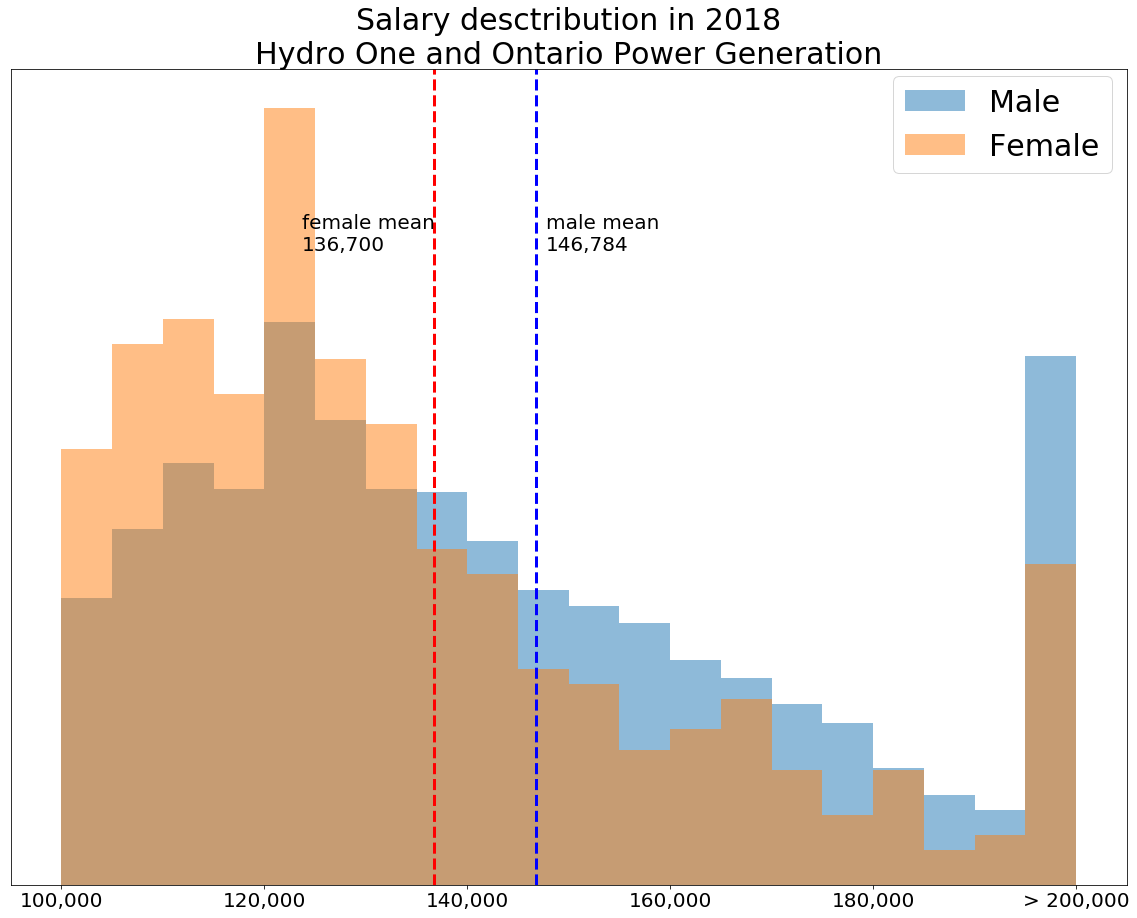

In [58]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(20,15))

df1 = df.copy()
df1 = df1[df1._gender_x=='male']
df1 = df1[df1._sector=='Hydro One and Ontario Power Generation']
df1 = df1[df1.c_year==2018]
male_mean = df1.salary_x.mean()
df1.salary_x = [i if i < 200000 else 200000 for i in df1.salary_x]

df2 = df.copy()
df2 = df2[df2._gender_x=='female']
df2 = df2[df2._sector=='Hydro One and Ontario Power Generation']
df2 = df2[df2.c_year==2018]
female_mean = df2.salary_x.mean()
df2.salary_x = [i if i < 200000 else 200000 for i in df2.salary_x]


# data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
# data = pd.DataFrame(data, columns=['x', 'y'])
# data.head()

# # for col in 'xy':
# #     plt.hist(data[col], normed=True, alpha=0.5)
plt.hist(df1.salary_x, normed=True, alpha=0.5, label='Male', bins=20)
plt.hist(df2.salary_x, normed=True, alpha=0.5, label='Female', bins=20)
plt.axvline(female_mean, color='r', linestyle='dashed', linewidth=3)
plt.axvline(male_mean, color='b', linestyle='dashed', linewidth=3)

plt.text(female_mean-13000, 0.000021, "female mean\n" + "{:,}".format((int(female_mean))), 
         color = 'black', fontsize=20)

plt.text(male_mean+1000, 0.000021, "male mean\n" + "{:,}".format((int(male_mean))), 
         color = 'black', fontsize=20)

plt.xticks([100000, 120000, 140000, 160000,180000, 200000], ['100,000','120,000','140,000','160,000','180,000','> 200,000'], fontsize=20)
plt.yticks([], [], fontsize=20)

plt.ylabel('', fontsize=40)
plt.xlabel('', fontsize=40)
plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))

plt.title("Salary desctribution in 2018\nHydro One and Ontario Power Generation", fontsize=30)

Text(0.5,1,'Salary desctribution in 2018\nC-suite jobs')

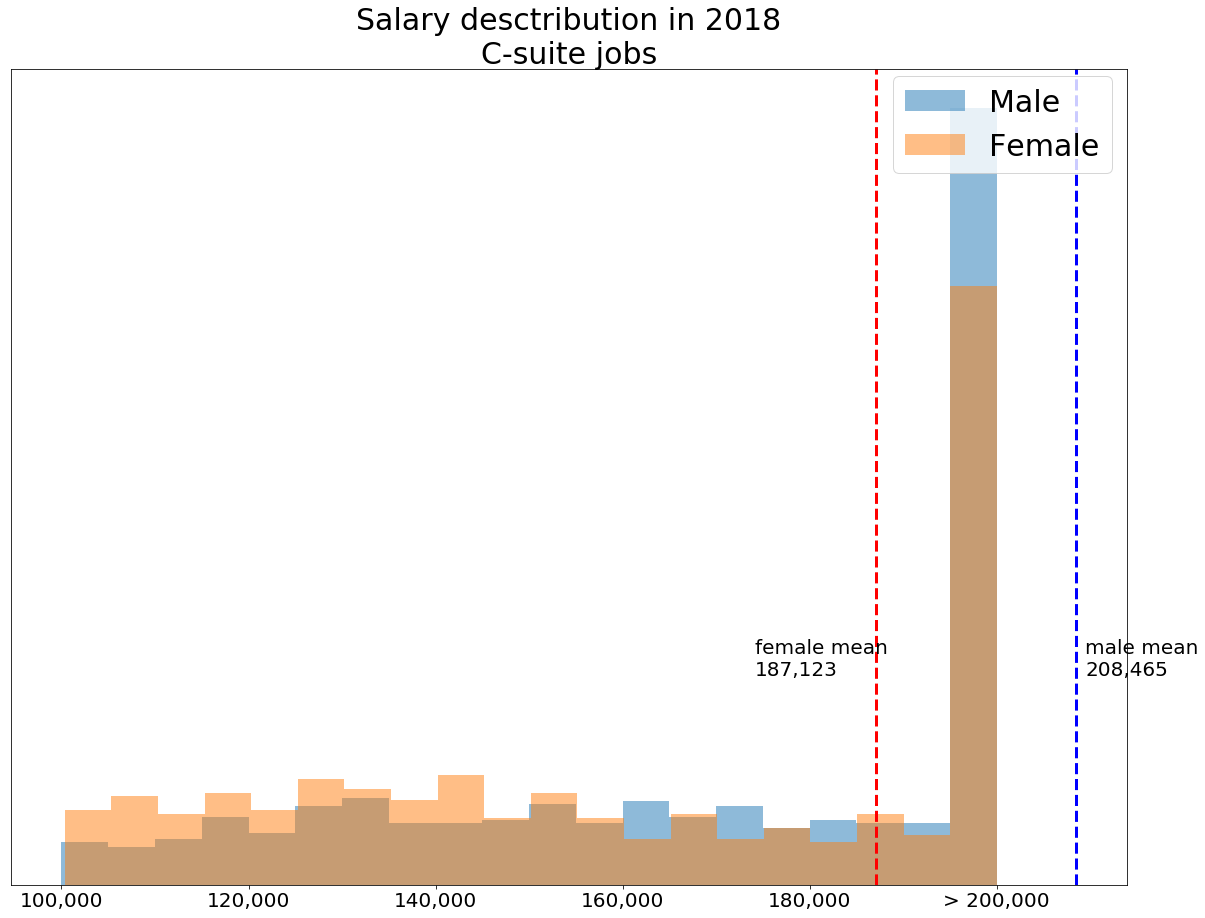

In [59]:


# Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(20,15))

df1 = df.copy()
df1 = df1[df1._gender_x=='male']
df1 = df1[df1.job_category2!='none']
df1 = df1[df1.c_year==2018]
male_mean = df1.salary_x.mean()
df1.salary_x = [i if i < 200000 else 200000 for i in df1.salary_x]

df2 = df.copy()
df2 = df2[df2._gender_x=='female']
df2 = df2[df2.job_category2!='none']
df2 = df2[df2.c_year==2018]
female_mean = df2.salary_x.mean()
df2.salary_x = [i if i < 200000 else 200000 for i in df2.salary_x]


# data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
# data = pd.DataFrame(data, columns=['x', 'y'])
# data.head()

# # for col in 'xy':
# #     plt.hist(data[col], normed=True, alpha=0.5)
plt.hist(df1.salary_x, normed=True, alpha=0.5, label='Male', bins=20)
plt.hist(df2.salary_x, normed=True, alpha=0.5, label='Female', bins=20)
plt.axvline(female_mean, color='r', linestyle='dashed', linewidth=3)
plt.axvline(male_mean, color='b', linestyle='dashed', linewidth=3)

plt.text(female_mean-13000, 0.000021, "female mean\n" + "{:,}".format((int(female_mean))), 
         color = 'black', fontsize=20)

plt.text(male_mean+1000, 0.000021, "male mean\n" + "{:,}".format((int(male_mean))), 
         color = 'black', fontsize=20)

plt.xticks([100000, 120000, 140000, 160000,180000, 200000], ['100,000','120,000','140,000','160,000','180,000','> 200,000'], fontsize=20)
plt.yticks([], [], fontsize=20)

plt.ylabel('', fontsize=40)
plt.xlabel('', fontsize=40)
plt.legend(loc="upper right", fontsize=30, title="", bbox_to_anchor=(1.0, 1.01))

plt.title("Salary desctribution in 2018\nC-suite jobs", fontsize=30)

Text(0.5,1,'Avg salary changes by year\n All Sectors')

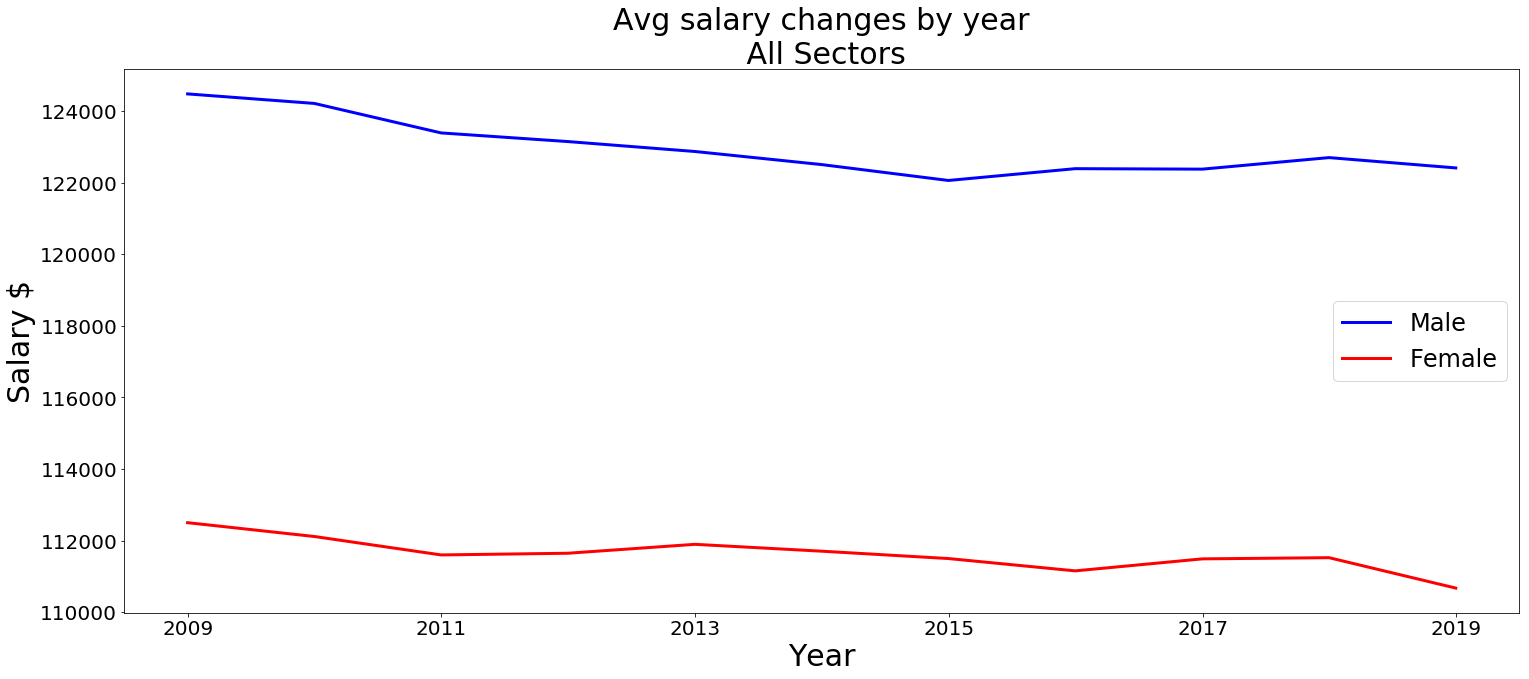

In [62]:
# df1 = df[df.job_category1=='none'].copy()
df1 = df.copy()

df1['observation_time'] = pd.to_datetime(df1['c_year'],format='%Y')
df1.index = df1['observation_time']
df2 = df1[df1._gender_x == 'female']
df1 = df1[df1._gender_x == 'male']


df1 = df1[['salary_m']]
df1.columns = ['salary_m']
df1 = df1.resample('Y').agg({"salary_m":'mean'})

df2 = df2[['salary_f']]
df2.columns = ['salary_f']
df2 = df2.resample('Y').agg({"salary_f":'mean'})

fig, ax = plt.subplots(figsize=(25,10))


plt.plot('salary_m', data=df1, markersize=12, color='blue', linewidth=3, label = 'Male')
plt.plot('salary_f', data=df2, markersize=12, color='r', linewidth=3, label = 'Female')
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Avg salary changes by year\n All Sectors", fontsize=30)

Text(0.5,1,'Avg salary changes by year\n Salaries adjusted to Canada Inflation Rates\nAll Sectors')

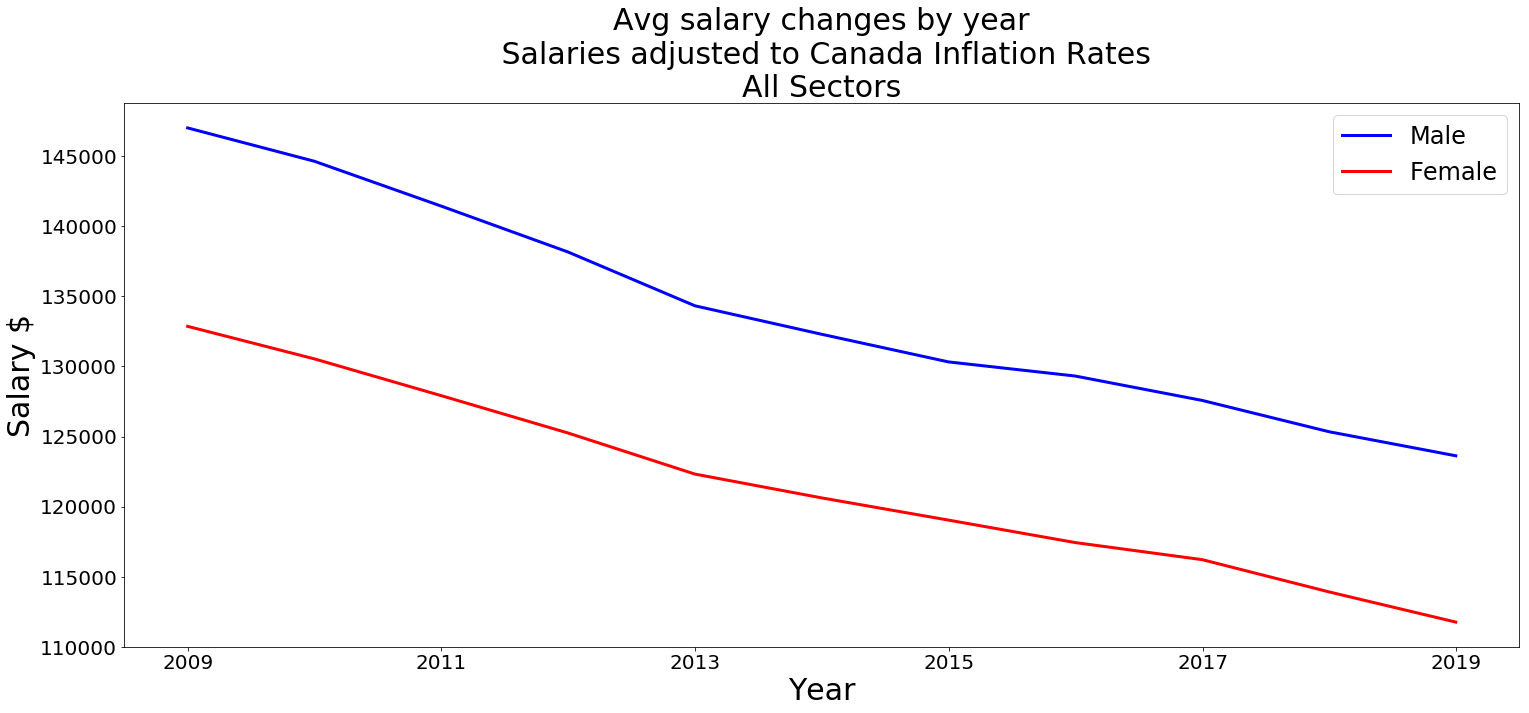

In [63]:
# df1 = df[df.job_category1=='none'].copy()
df1 = df.copy()

df1['observation_time'] = pd.to_datetime(df1['c_year'],format='%Y')
df1.index = df1['observation_time']
df2 = df1[df1._gender_x == 'female']
df1 = df1[df1._gender_x == 'male']


df1 = df1[['salary_adjusted_m']]
df1.columns = ['salary_adjusted_m']
df1 = df1.resample('Y').agg({"salary_adjusted_m":'mean'})

df2 = df2[['salary_adjusted_f']]
df2.columns = ['salary_adjusted_f']
df2 = df2.resample('Y').agg({"salary_adjusted_f":'mean'})

fig, ax = plt.subplots(figsize=(25,10))


plt.plot('salary_adjusted_m', data=df1, markersize=12, color='blue', linewidth=3, label = 'Male')
plt.plot('salary_adjusted_f', data=df2, markersize=12, color='r', linewidth=3, label = 'Female')
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Avg salary changes by year\n Salaries adjusted to Canada Inflation Rates\nAll Sectors", fontsize=30)

Text(0.5,1,'Avg salary changes by year\nSalaries adjusted to Canada Inflation Rates\nNON C-Suite Jobs\n All Sectors')

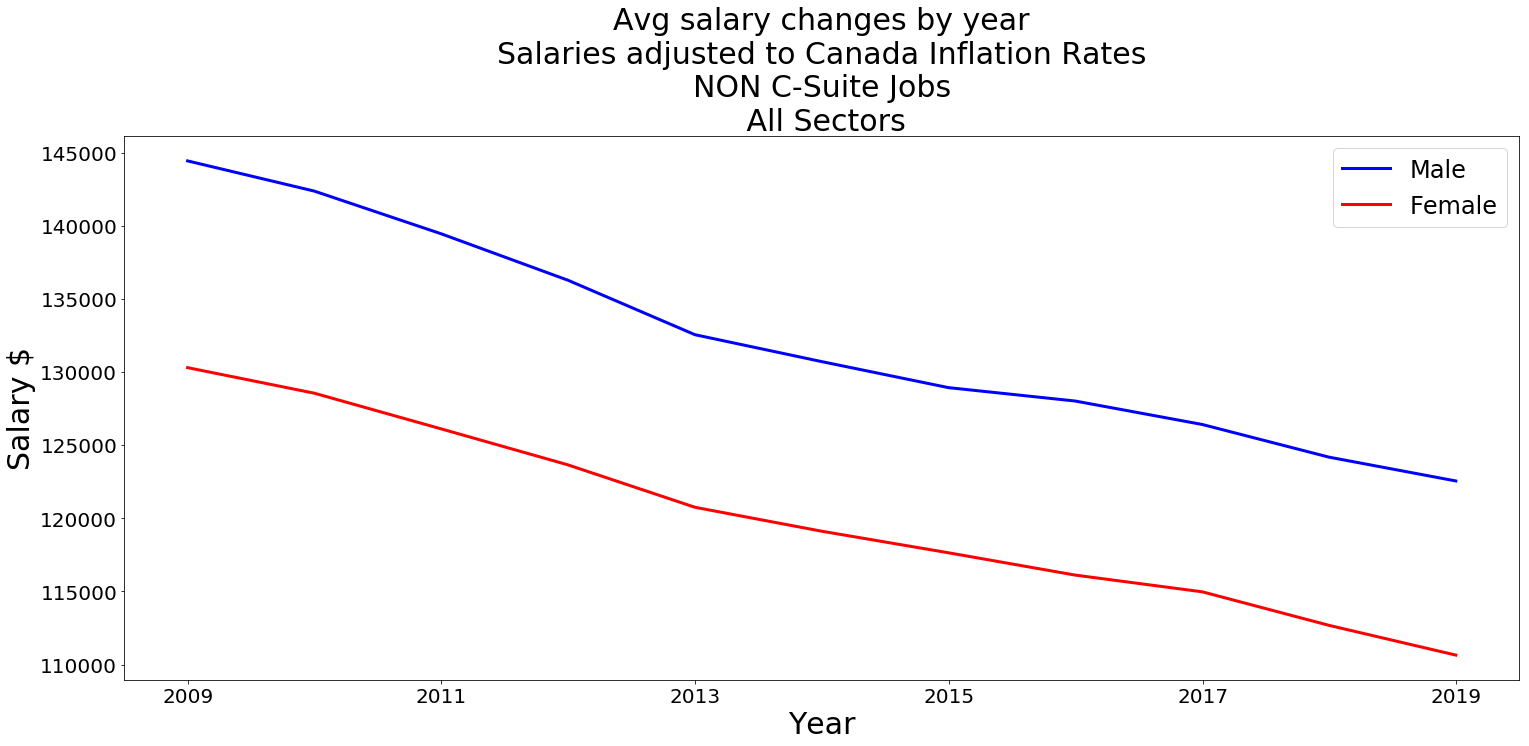

In [64]:
df1 = df[df.job_category1=='none'].copy()

df1['observation_time'] = pd.to_datetime(df1['c_year'],format='%Y')
df1.index = df1['observation_time']
df2 = df1[df1._gender_x == 'female']
df1 = df1[df1._gender_x == 'male']


df1 = df1[['salary_adjusted_m']]
df1.columns = ['salary_adjusted_m']
df1 = df1.resample('Y').agg({"salary_adjusted_m":'mean'})

df2 = df2[['salary_adjusted_f']]
df2.columns = ['salary_adjusted_f']
df2 = df2.resample('Y').agg({"salary_adjusted_f":'mean'})

fig, ax = plt.subplots(figsize=(25,10))


plt.plot('salary_adjusted_m', data=df1, markersize=12, color='blue', linewidth=3, label = 'Male')
plt.plot('salary_adjusted_f', data=df2, markersize=12, color='r', linewidth=3, label = 'Female')
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Avg salary changes by year\nSalaries adjusted to Canada Inflation Rates\nNON C-Suite Jobs\n All Sectors", fontsize=30)

Text(0.5,1,'Avg salary changes by year\nSalaries adjusted to Canada Inflation Rates\nC-Suite Jobs\n All Sectors')

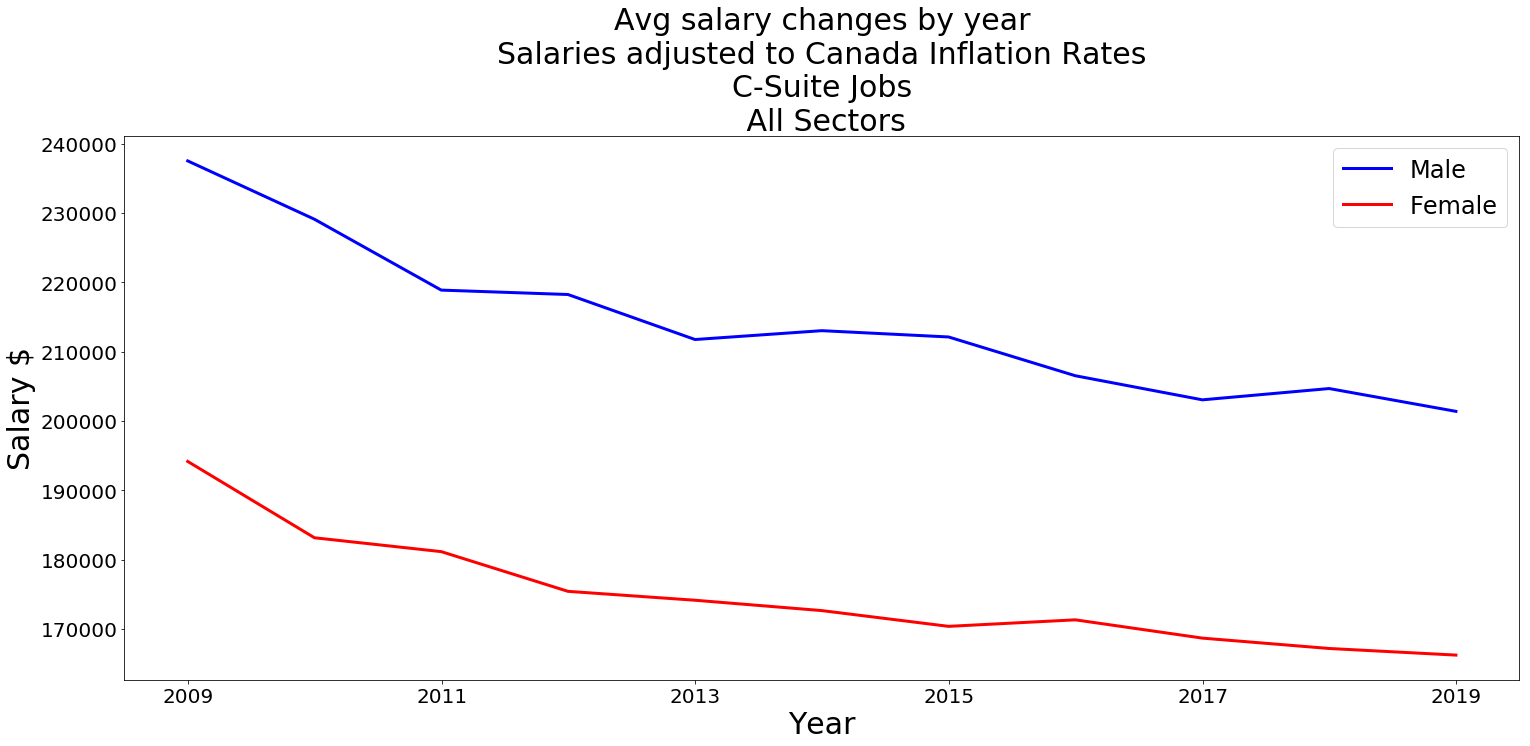

In [65]:
df1 = df[df.job_category2!='none'].copy()

df1['observation_time'] = pd.to_datetime(df1['c_year'],format='%Y')
df1.index = df1['observation_time']
df2 = df1[df1._gender_x == 'female']
df1 = df1[df1._gender_x == 'male']


df1 = df1[['salary_adjusted_m']]
df1.columns = ['salary_adjusted_m']
df1 = df1.resample('Y').agg({"salary_adjusted_m":'mean'})

df2 = df2[['salary_adjusted_f']]
df2.columns = ['salary_adjusted_f']
df2 = df2.resample('Y').agg({"salary_adjusted_f":'mean'})

fig, ax = plt.subplots(figsize=(25,10))


plt.plot('salary_adjusted_m', data=df1, markersize=12, color='blue', linewidth=3, label = 'Male')
plt.plot('salary_adjusted_f', data=df2, markersize=12, color='r', linewidth=3, label = 'Female')
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Avg salary changes by year\nSalaries adjusted to Canada Inflation Rates\nC-Suite Jobs\n All Sectors", fontsize=30)

Text(0.5,1,'Avg salary changes by year\nC-Suite Jobs\n All Sectors')

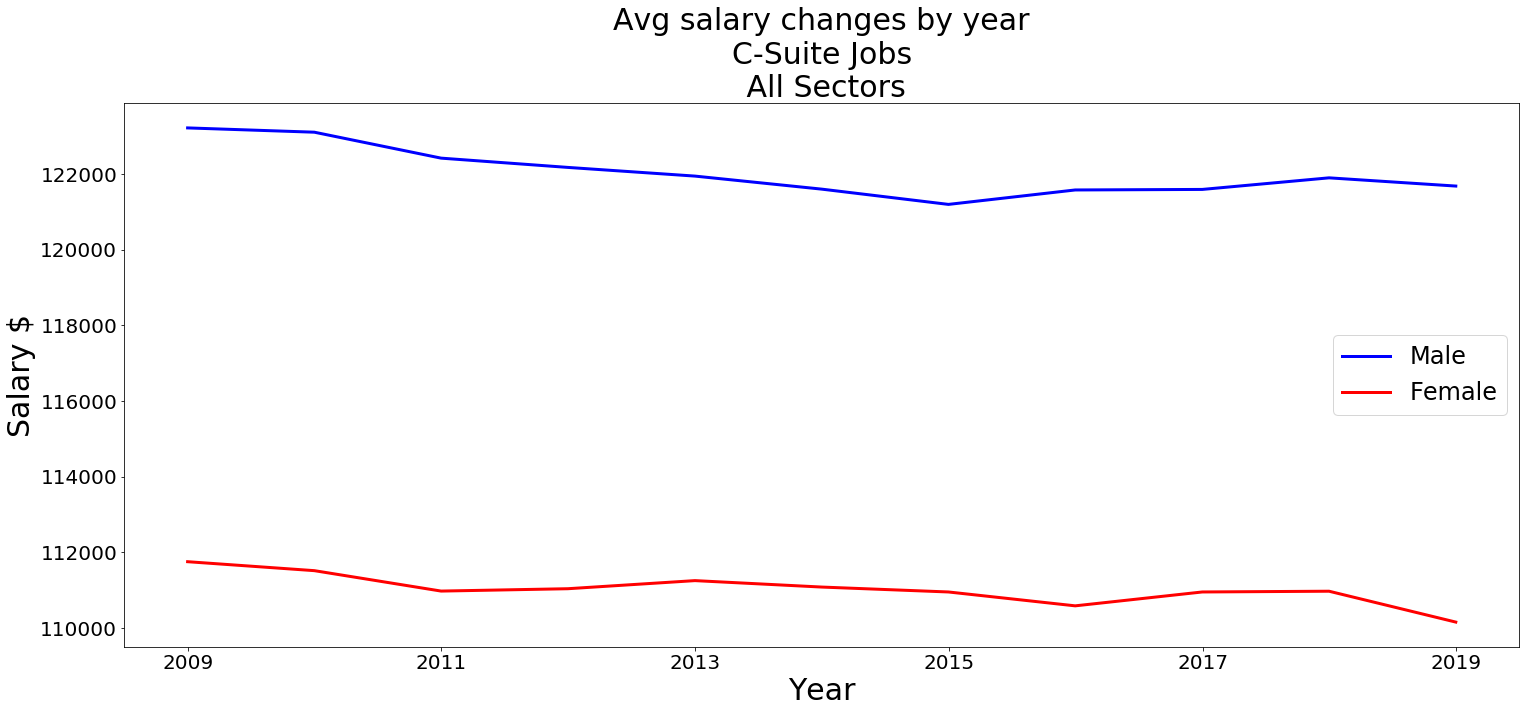

In [66]:
df1 = df[df.job_category2=='none'].copy()

df1['observation_time'] = pd.to_datetime(df1['c_year'],format='%Y')
df1.index = df1['observation_time']
df2 = df1[df1._gender_x == 'female']
df1 = df1[df1._gender_x == 'male']


df1 = df1[['salary_m']]
df1.columns = ['salary_m']
df1 = df1.resample('Y').agg({"salary_m":'mean'})

df2 = df2[['salary_f']]
df2.columns = ['salary_f']
df2 = df2.resample('Y').agg({"salary_f":'mean'})

fig, ax = plt.subplots(figsize=(25,10))


plt.plot('salary_m', data=df1, markersize=12, color='blue', linewidth=3, label = 'Male')
plt.plot('salary_f', data=df2, markersize=12, color='r', linewidth=3, label = 'Female')
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Salary $', fontsize=30)
plt.xlabel('Year', fontsize=30)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Avg salary changes by year\nC-Suite Jobs\n All Sectors", fontsize=30)


# Identify top 5 and bottom 5 employers (by representation) with 100+ employees:

In [104]:
df1 = df[df.c_year==2018]
df1 = df1[df1.culture>0]

df1 = df1[df1['counts_by_year_employer']>20]
df1.num_of_ceo_ratings.fillna(-1, inplace=True)
df1 = df1[df1['num_of_ceo_ratings'].astype(int)>10]


In [105]:
df1['female_salary_percent_year_employer']=[round(i/100,2) for i in df1.female_salary_percent_year_employer]
dd = df1.groupby(['female_salary_percent_year_employer'])['company',
       'work_life', 'salary_y', 'job_security', 'management', 'culture', 'ceo', 'avg_indeed_score'].mean()
dd.reset_index(inplace=True)
dd

,female_salary_percent_year_employer,work_life,salary_y,job_security,management,culture,ceo,avg_indeed_score
0,0.43,3.747811,3.531524,3.429247,3.474781,3.628984,82.869527,3.562469
1,0.44,3.784956,3.827434,3.392920,3.487611,3.779646,82.380531,3.654513
2,0.45,3.774803,4.027330,3.572038,3.439494,3.683136,74.223144,3.699360
3,0.46,4.000000,3.800000,3.700000,3.800000,3.900000,88.000000,3.840000
4,0.47,4.191831,3.822518,3.782728,3.994742,4.149742,85.823332,3.988312
5,0.48,4.174119,4.112887,3.731294,3.827290,3.961279,86.139414,3.961374
6,0.49,4.046271,3.955298,3.710387,3.748960,3.875619,81.393736,3.867307
7,0.50,4.188682,3.938153,3.792095,3.892556,4.049916,87.246226,3.972280
8,0.51,4.133330,3.884715,3.614295,3.678151,3.848226,82.529314,3.831743
9,0.52,4.400000,3.900000,4.000000,4.000000,4.200000,92.000000,4.100000


Text(0.5,1,'Salary Equality By Gender, 2018 \n All Sectors')

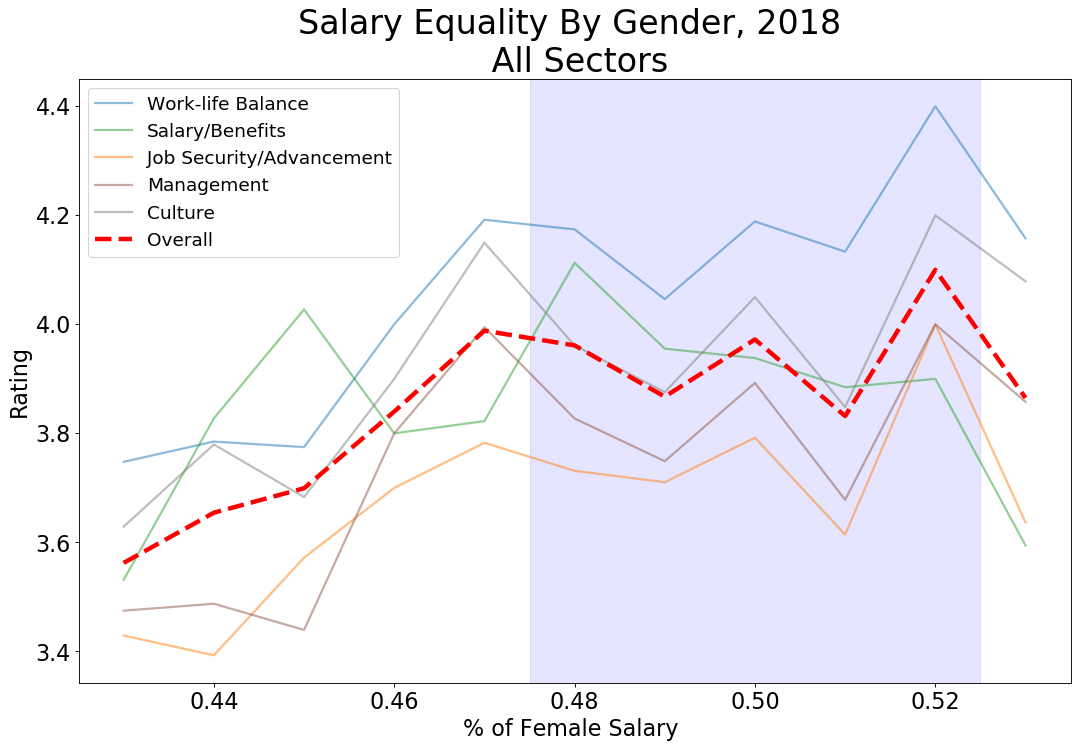

In [106]:
# Draw Plot
mycolors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 
            'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 
            'firebrick', 'mediumseagreen']      
plt.figure(figsize=(16,10), dpi= 80)

cats = ['work_life','salary_y','job_security','management','culture']
lables = ['Work-life Balance','Salary/Benefits','Job Security/Advancement','Management','Culture']

ctr = 0
for i in cats:
    plt.plot('female_salary_percent_year_employer', i, data=dd, color=mycolors[ctr], label=lables[ctr], alpha = 0.5, linewidth = 2)
    ctr += 1
    
plt.plot('female_salary_percent_year_employer', 'avg_indeed_score', data=dd, 
         color='r', label='Overall', linewidth = 4, linestyle='--')

# plt.plot('female_salary_percent_year_employer', 'ceo', data=dd, 
#          color='g', label='CEO approval rating', linewidth = 2, linestyle='--')

plt.axvspan(0.475, 0.525, color='b', alpha=0.1)

plt.legend(loc="top right", fontsize='small')
plt.ylabel('Rating', fontsize=20)
plt.xlabel('% of Female Salary ', fontsize=20)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)
   
plt.title("Salary Equality By Gender, 2018 \n All Sectors", fontsize=30)

In [107]:
df1 = df1[df1['counts_by_year_employer']>20]
df1.num_of_ceo_ratings.fillna(-1, inplace=True)
df1 = df1[df1['num_of_ceo_ratings'].astype(int)>10]

# dd = df1.groupby(['indeed_score_percentile']).agg({'female_percent_year_employer':np.mean,'female_salary_percent_year_employer':np.mean,'avg_indeed_score':np.mean })
# dd.reset_index(inplace=True)
# dd.columns= ['indeed score percentile', '% of female', 'female salary % ', 'indeed score']
# dd

df1.female_percent_year_employer = [round(i,2) for i in df1.female_percent_year_employer]
dd = df1.groupby(['female_percent_year_employer'])['company',
       'work_life', 'salary_y', 'job_security', 'management', 'culture', 'ceo', 'avg_indeed_score'].mean()
dd.reset_index(inplace=True)
dd

,female_percent_year_employer,work_life,salary_y,job_security,management,culture,ceo,avg_indeed_score
0,0.04,3.800000,4.400000,3.700000,3.800000,4.100000,83.000000,3.960000
1,0.14,4.000000,3.600000,3.400000,3.600000,3.600000,78.000000,3.640000
2,0.15,3.800000,4.300000,3.900000,3.600000,3.800000,73.000000,3.880000
3,0.16,4.400000,3.900000,4.000000,4.000000,4.200000,92.000000,4.100000
4,0.17,4.200000,4.400000,3.800000,3.800000,3.900000,88.000000,4.020000
5,0.18,3.600000,3.300000,3.100000,3.300000,3.400000,77.000000,3.340000
6,0.19,4.200000,3.800000,3.800000,3.800000,4.000000,84.000000,3.920000
7,0.20,3.904939,4.275305,3.885183,3.980244,4.180244,90.407314,4.045183
8,0.21,4.176954,3.887350,3.758851,3.891821,4.032134,85.786623,3.949422
9,0.22,4.022222,3.633333,3.511111,3.522222,3.911111,80.333333,3.720000


Text(0.5,1,"Gender Balance vs company's ratings, 2018 \n All Sectors")

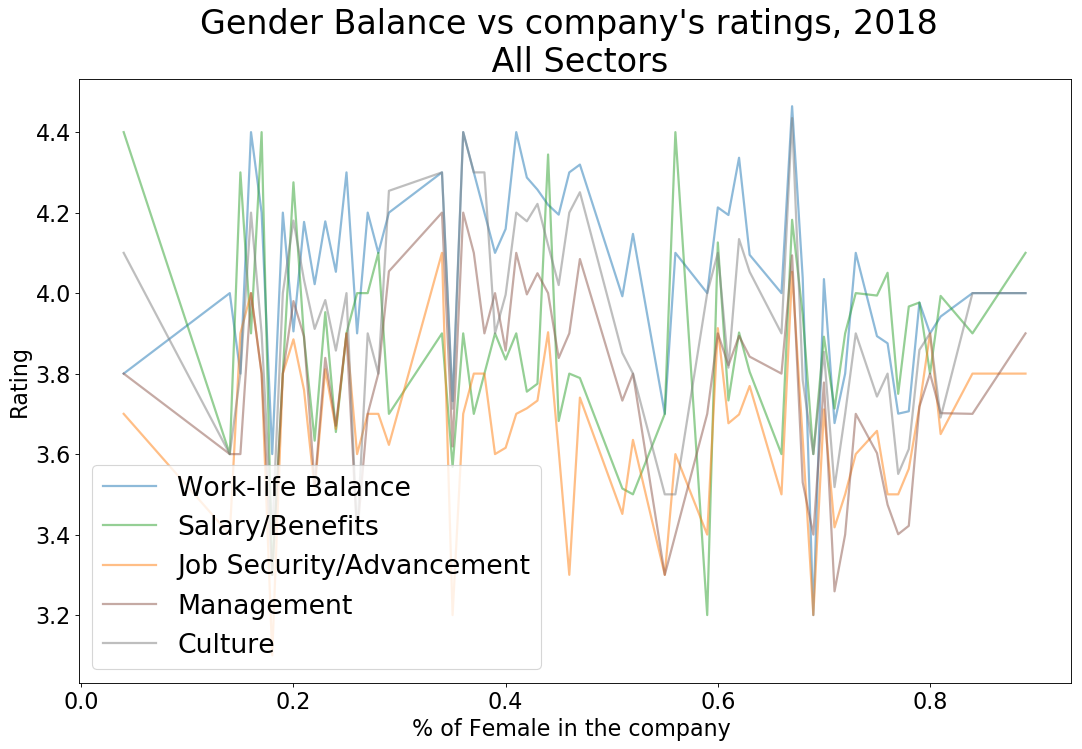

In [110]:
# Draw Plot
mycolors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 
            'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 
            'firebrick', 'mediumseagreen']      
plt.figure(figsize=(16,10), dpi= 80)

    
cats = ['work_life','salary_y','job_security','management','culture']
lables = ['Work-life Balance','Salary/Benefits','Job Security/Advancement','Management','Culture']

ctr = 0
for i in cats:
    plt.plot('female_percent_year_employer', i, data=dd, color=mycolors[ctr], label=lables[ctr], alpha = 0.5, linewidth = 2)
    ctr += 1
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Rating', fontsize=20)
plt.xlabel('% of female in the company', fontsize=20)

plt.legend(loc="top right", fontsize='large')
plt.ylabel('Rating', fontsize=20)
plt.xlabel('% of Female in the company ', fontsize=20)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Gender Balance vs company's ratings, 2018 \n All Sectors", fontsize=30)

Text(0.5,1,'Gender Balance vs CEO approval, 2018 \n All Sectors')

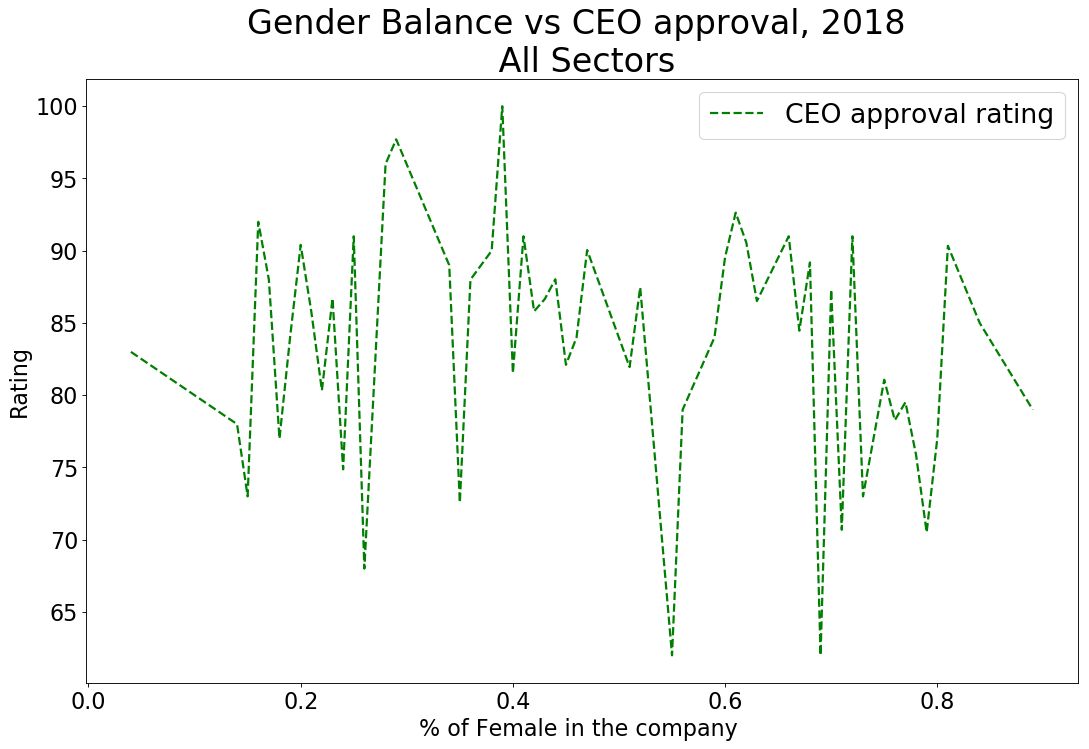

In [112]:
# Draw Plot
mycolors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 
            'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 
            'firebrick', 'mediumseagreen']      
plt.figure(figsize=(16,10), dpi= 80)

    
cats = ['work_life','salary_y','job_security','management','culture']
lables = ['Work-life Balance','Salary/Benefits','Job Security/Advancement','Management','Culture']


plt.plot('female_percent_year_employer', 'ceo', data=dd, 
         color='g', label='CEO approval rating', linewidth = 2, linestyle='--')
    
    
plt.legend(loc="top right", fontsize='large')
plt.ylabel('Rating', fontsize=20)
plt.xlabel('% of female in the company', fontsize=20)

plt.legend(loc="top right", fontsize='large')
plt.ylabel('Rating', fontsize=20)
plt.xlabel('% of Female in the company ', fontsize=20)

for item in ax.get_yticklabels():
    item.set_fontsize(20)
for item in ax.get_xticklabels():
    item.set_fontsize(20)

plt.title("Gender Balance vs CEO approval, 2018 \n All Sectors", fontsize=30)